In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
import src.utils_contributions as utils_contributions
from src.contributions import ModelWrapper
from extract_explanations import read_blimp_dataset, tokens2words, read_sva_dataset, read_ioi_dataset
import pickle
from lm_saliency import *
from collections import defaultdict
import pandas as pd
import seaborn as sns
import statistics

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Currently works for:
#  OPT: facebook/opt-125m
#  GPT_-Neo: EleutherAI/gpt-neo-125M, EleutherAI/gpt-neo-2.7B
#  GPT-2: gpt2 (124M), gpt2-large (774M), gpt2-xl (1.5B)
# bigscience/bloom-560m
name_path = 'gpt2'
_, tokenizer = utils_contributions.load_model_tokenizer(name_path,only_tokenizer=True)
name_path = name_path.replace('/','-')


In [4]:
# dataset = 'anaphor_gender_agreement'
# info_sentence_results_file = f'./results/{name_path}/{dataset}_info_sentence.csv'

# df_logits_diff = pd.read_csv(info_sentence_results_file, delimiter='|')
# df_logits_diff[df_logits_diff['logit_diff']<2]

In [5]:
subset = 'ioi'
info_sentence_results_file = f'./results/{name_path}/{subset}_info_sentence.csv'
df_logits_diff = pd.read_csv(info_sentence_results_file, delimiter='|')
df_logits_diff[df_logits_diff['logit_diff']<0]

sentence  logit_diff  \
7    After the lunch, Martha and Theresa went to th...   -0.087299   
24   After the lunch, Virginia and Geneva went to t...   -0.070625   
40   When Paula and Martha got a coconut at the zoo...   -0.254395   
77   After the lunch, Fannie and Deanna went to the...   -1.400284   
116  The forest Ella and Bernadette went to had a o...   -0.363785   
122  When Theresa and Eleanor got a cherry at the m...   -2.371307   
124  The lake Chelsea and Kristina went to had a ap...   -2.400139   
158  While Dianne and Shannon were working at the p...   -1.368629   
176  While Virginia and Martha were working at the ...   -0.346642   
194  When Theresa and Natasha got a watermelon at t...   -0.865395   
216  While Dianne and Erika were working at the the...   -0.883514   
280  The forest Alyssa and Inez went to had a black...   -0.288765   
284  Then, Virginia and Marsha were thinking about ...   -0.759254   
348  After the lunch, Ginger and Inez went to the f...   -0.642197   
412  After the lunch, Virginia and Martha went to t...   -1.158501   
428  Then, Kathryn and Inez were thinking about goi...   -0.985291   
456  The river Marian and Sonia went to had a peach...   -3.024101   
470  Then, Jacqueline and Ethel had a lot of fun at...   -0.423721   
494  Then, Brandy and Ethel had a lot of fun at the...   -0.146988   
568  Then, Theresa and Inez had a lot of fun at the...   -0.164787   
631  Then, Jackie and Jacqueline were working at th...   -0.668068   
672  When Mildred and Martha got a peach at the for...   -1.113762   
694  The river Yolanda and Natasha went to had a ho...   -1.150337   
696  The river Ella and Megan went to had a pear. M...   -2.733299   
716  Then, Kathryn and Jackie were thinking about g...   -0.054497   
747  Then, Pauline and Wilma were thinking about go...   -0.171669   
776  The river Leona and Lula went to had a strawbe...   -0.560638   
784  While Virginia and Eleanor were working at the...   -0.322205   
785  Then, Fannie and Mildred were working at the m...   -0.056686   
802  While Virginia and Megan were commuting to the...   -1.337433   
817  Then, Melissa and Dianne were thinking about g...   -0.734367   
844  When Theresa and Lula got a watermelon at the ...   -0.211113   
854  When Kathryn and Inez got a grape at the river...   -0.188919   
872  When Virginia and Martha got a raspberry at th...   -2.386093   
896  Then, Wilma and Stacey were thinking about goi...   -0.003410   
904  The beach Dianne and Irma went to had a papaya...   -0.172272   
911  Friends Kristina and Brandy found a mango at t...   -0.093060   
942  While Deanna and Sophia were commuting to the ...   -0.334076   
972  While Theresa and Inez were working at the des...   -0.818077   
978  After Theresa and Sonia went to the theater, S...   -0.278648   

     correct_id  foil_id  
7         20251    27243  
24         6025    20552  
40        36025    27243  
77         1024      376  
116        7122     6206  
122       20251    45566  
124       12147    14912  
158       49197    28108  
176        6025    27243  
194       20251    41875  
216       49197      412  
280         317      554  
284        6025     8706  
348       38682      554  
412        6025    27243  
428       48674      554  
456       37919    20733  
470       44726      412  
494        1709      412  
568       20251      554  
631       44726    24766  
672       29087    27243  
694         575    41875  
696        7122    27616  
716       48674    24766  
747        5187     3362  
776        1004      406  
784        6025    45566  
785       29087      376  
802        6025    27616  
817       49197    24164  
844       20251      406  
854       48674      554  
872        6025    27243  
896        5187      520  
904       49197    41224  
911        1709    14912  
942        1024    39953  
972       20251      554  
978       20251    20733

In [6]:
# dataset = 'blimp'

# if dataset == 'blimp':
#     subsets = ['anaphor_gender_agreement',
#         'anaphor_number_agreement',
#         'animate_subject_passive',
#         'determiner_noun_agreement_1',
#         'determiner_noun_agreement_irregular_1',
#         'determiner_noun_agreement_with_adjective_1',
#         'determiner_noun_agreement_with_adj_irregular_1',
#         'npi_present_1',
#         'distractor_agreement_relational_noun']
#         # 'irregular_plural_subject_verb_agreement_1',
#         # 'regular_plural_subject_verb_agreement_1']
#     #subsets = ['anaphor_gender_agreement']
# elif dataset == 'sva':
#     subsets = ['sva_1', 'sva_2', 'sva_3', 'sva_4']
# elif dataset == 'ioi':
#     subsets = ['ioi']

In [5]:
datasets = {'blimp': ['anaphor_gender_agreement',
            'anaphor_number_agreement',
            'animate_subject_passive',
            'determiner_noun_agreement_1',
            'determiner_noun_agreement_irregular_1',
            'determiner_noun_agreement_with_adjective_1',
            'determiner_noun_agreement_with_adj_irregular_1',
            'npi_present_1',
            'distractor_agreement_relational_noun'],
            'sva': ['sva_1', 'sva_2', 'sva_3', 'sva_4'],
            'ioi': ['ioi']}

In [6]:
# datasets = ['blimp', 'sva', 'ioi']
# total_subsets = []
# for dataset in datasets:
#     if dataset == 'blimp':
#         subsets = ['anaphor_gender_agreement',
#             'anaphor_number_agreement',
#             'animate_subject_passive',
#             'determiner_noun_agreement_1',
#             'determiner_noun_agreement_irregular_1',
#             'determiner_noun_agreement_with_adjective_1',
#             'determiner_noun_agreement_with_adj_irregular_1',
#             'npi_present_1',
#             'distractor_agreement_relational_noun']
#             # 'irregular_plural_subject_verb_agreement_1',
#             # 'regular_plural_subject_verb_agreement_1']
#         #subsets = ['anaphor_gender_agreement']
#     elif dataset == 'sva':
#         subsets = ['sva_1', 'sva_2', 'sva_3', 'sva_4']
#     elif dataset == 'ioi':
#         subsets = ['ioi']
#     total_subsets.append(subsets)
# total_subsets = [item for sublist in total_subsets for item in sublist]
# total_subsets

In [27]:
from src.utils_evaluation import read_subset, read_attribution_scores, read_sentence_target_foil, tokenize_target_foil, get_ground_truth_tokens
from scipy.stats import rankdata

results_dict = {}
results_dict_raw = {}

metric = 'mrr'

only_fails = False
only_corrects = False

methods_list = ['erasure', 'ours', 'grad']
methods_list = ['ours']


distance_subset = defaultdict(list)
for dataset in ['sva']:#datasets.keys()
    for subset in datasets[dataset]:
        print(subset)
        # Read datasets from csv as DataFrames
        df, num_examples = read_subset(subset)
        results_method = {}
        results_method_raw = {}

        info_sentence_results_file = f'./results/{name_path}/{subset}_info_sentence.csv'

        df_logits_diff = pd.read_csv(info_sentence_results_file, delimiter='|')
        #df_logits_diff[df_logits_diff['logit_diff']<0]
        fail_examples = df_logits_diff[df_logits_diff['logit_diff']<0].index.tolist()
        correct_examples = df_logits_diff[df_logits_diff['logit_diff']>0].index.tolist()

        # Iterate over every method
        for idx_method, method in enumerate(methods_list):
            print('method', method)

            # Read json files with attribtuion scores
            explanations_dict = read_attribution_scores(name_path, dataset, subset, method)
            # Read pickle file with logits information
            with open(f'./results/logits/{subset}_{name_path}.pickle', 'rb') as handle:
                logits_file = pickle.load(handle)

            expla_type_results = {}
            expla_type_results_raw = defaultdict(list)
            # Initialize explanation types results to zero
            for expla_type in explanations_dict.keys():
                if 'layerwise' in expla_type:
                    continue
                # Make sure the total number of sentences with explanations in json
                # is equal to num_examples
                assert len(explanations_dict[expla_type]) == num_examples
                expla_type_results[expla_type] = 0
            # Initialize random baseline to zero
            if idx_method == len(methods_list)-1:
                # If last  method in list, compute random baseline
                expla_type_results['random'] = 0

            counter = 0

            #num_examples = 1
            for idx in range(num_examples):
                if only_fails == True:
                    if idx not in fail_examples:
                        continue
                elif only_fails == False and only_corrects == True:
                    if idx not in correct_examples:
                        continue
                    
                text, target, foil = read_sentence_target_foil(df, subset, idx)
                CORRECT_ID, FOIL_ID, min_length = tokenize_target_foil(name_path, tokenizer, target, foil)
                pt_batch = tokenizer(text, return_tensors="pt").to(device)
                tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])
                print(f'\ntokenized_text {tokenized_text}')

                # If target and foil are the same continue
                if CORRECT_ID == FOIL_ID:
                    continue

                ground_truth_binary_vector, gt_token_pos = get_ground_truth_tokens(subset, text, target, tokenizer, df, idx)
                print(f'GT pos({gt_token_pos}): {ground_truth_binary_vector}')
                if ground_truth_binary_vector is None:
                    continue

                if logits_file[idx] == 'NA':
                    # Continue if seq_length > min_length
                    if len(tokenized_text)>min_length:
                        continue
                if idx_method == 0:
                    distance_subset[subset].append(len(tokenized_text) - gt_token_pos[-1])

                for expla_type in explanations_dict.keys():
                    if 'layer' in expla_type:
                        continue
                    contribs_input_tok = np.asarray(explanations_dict[expla_type][idx])                
                    
                    if len(tokenized_text) == min_length:
                        # Add case where there is just one token before prediction (probes needed changes)
                        # if not considered
                        # We create an array of ones (opt requires </s>)
                        contribs_input_tok = np.ones(min_length)

                    # Normalize ours contributions
                    if 'logit' in expla_type:
                        if logits_file[idx] != 'NA':
                            # Add init logit diff
                            if 'layer' not in expla_type:
                                # Add embedding logit to last res stream
                                init_logits_diff = logits_file[idx]['init_logit'][0] - logits_file[idx]['init_logit'][1]
                                contribs_input_tok[-1] += init_logits_diff
                            #print(f'contribs_input_tok {expla_type} {contribs_input_tok}')
                            if metric is not 'dot_product':
                                norm = np.linalg.norm(contribs_input_tok, ord=1)
                                contribs_input_tok /= norm
                    if metric == 'dot_product':
                        # Dot-product alignment metric
                        expla_type_results[expla_type] += np.matmul(contribs_input_tok, ground_truth_binary_vector)
                        #print(f'contribs_input_tok {expla_type} {contribs_input_tok}')
                        expla_type_results_raw[expla_type].append(np.matmul(contribs_input_tok, ground_truth_binary_vector))
                    elif metric == 'mrr':
                        # Mean Reciprocal Rank
                        rank_ascending = rankdata(contribs_input_tok, method='dense', axis = -1)
                        rank_descending = len(rank_ascending) - rank_ascending + 1
                        if expla_type == 'logit_attn_full' or expla_type == 'logit_attn_full_alti':
                            print(f'{idx}: {expla_type} / {min(rank_descending[gt_token_pos])} / {contribs_input_tok}')
                        expla_type_results[expla_type] += 1/(min(rank_descending[gt_token_pos]))
                        
                    elif metric == 'probes':
                        # Probes Needed
                        rank_ascending = rankdata(contribs_input_tok, method='dense', axis = -1)
                        rank_descending = len(rank_ascending) - rank_ascending
                        expla_type_results[expla_type] += min(rank_descending[gt_token_pos])

                #Add random baseline
                if idx_method == len(methods_list)-1:
                    # If last method in list, compute random baseline
                    random_explanations = np.random.uniform(low=0.0, high=1.0, size=ground_truth_binary_vector.shape[0])
                    if metric == 'dot_product':
                        norm = np.linalg.norm(random_explanations, ord=1)
                        random_explanations /= norm
                        expla_type_results['random'] += np.matmul(random_explanations, ground_truth_binary_vector)
                    elif metric == 'mrr':
                        rank_ascending = rankdata(random_explanations, method='dense', axis = -1)
                        rank_descending = len(rank_ascending) - rank_ascending + 1
                        expla_type_results['random'] += 1/(min(rank_descending[gt_token_pos]))
                    elif metric == 'probes':
                        rank_ascending = rankdata(random_explanations, method='dense', axis = -1)
                        rank_descending = len(rank_ascending) - rank_ascending
                        expla_type_results['random'] += min(rank_descending[gt_token_pos])
                counter += 1
            
            print('counter', counter)
            
            for expla_type in expla_type_results.keys():
                expla_type_results[expla_type] /= counter
                print(f'{expla_type}', expla_type_results[expla_type])
                results_method[expla_type] = expla_type_results[expla_type]
                results_method_raw[expla_type] = expla_type_results_raw[expla_type]
            results_dict[subset] = results_method
            results_dict_raw[subset] = results_method_raw

            print()
            print()

            print(len(distance_subset[subset]))
            print('distance to evidence', statistics.mean(distance_subset[subset]))

anaphor_gender_agreement
method ours
./results/blimp/anaphor_gender_agreement_gpt2_ours.json

tokenized_text ['K', 'atherine', 'Ġcan', "'t", 'Ġhelp']
GT pos([0, 1]): [1. 1. 0. 0. 0.]

tokenized_text ['Kar', 'la', 'Ġcould', 'Ġlisten', 'Ġto']
GT pos([0, 1]): [1. 1. 0. 0. 0.]

tokenized_text ['Marie', 'Ġwon', "'t", 'Ġthink', 'Ġabout']
GT pos([0]): [1. 0. 0. 0. 0.]

tokenized_text ['Mark', 'Ġhasn', "'t", 'Ġdiscussed']
GT pos([0]): [1. 0. 0. 0.]

tokenized_text ['Stephen', 'Ġimpressed']
GT pos([0]): [1. 0.]

tokenized_text ['Christ', 'ina', 'Ġboasts', 'Ġabout']
GT pos([0, 1]): [1. 1. 0. 0.]

tokenized_text ['Su', 'zanne', 'Ġwould', 'Ġirrit', 'ate']
GT pos([0, 1]): [1. 1. 0. 0. 0.]

tokenized_text ['Rose', 'Ġcouldn', "'t", 'Ġreference']
GT pos(None): None

tokenized_text ['Paul', 'Ġshould', 'Ġstun']
GT pos([0]): [1. 0. 0.]

tokenized_text ['Krist', 'en', 'Ġpraises']
GT pos([0, 1]): [1. 1. 0.]

tokenized_text ['Tam', 'ara', 'Ġmight', 'Ġwork', 'Ġwith']
GT pos([0, 1]): [1. 1. 0. 0. 0.]

tokeniz

In [ ]:
df_results = pd.DataFrame(results_dict).round(3)
display(df_results.transpose()[['logit_attn_full', 'logit_attn_full_alti']])
print(df_results.transpose().mean())

if metric == 'mrr':
    ascending = False
elif metric == 'probes':
    ascending = True
elif metric == 'dot_product':
  ascending = False

df_results_ranks = df_results.loc[['erasure', 'logit_attn_full', 'logit_attn_full_alti', 'grad_norm_2','grad_inp_2']].rank(ascending=ascending, method='min')
df_results_ranks.transpose()

In [20]:
import os
os.makedirs(f'./results/tables/all_datasets/', exist_ok = True)

if only_fails:
    df_results.transpose().to_csv(f'results/tables/all_datasets/fail_{name_path}_{metric}.csv')
    df_results_ranks.transpose().to_csv(f'results/tables/all_datasets/fail_{name_path}_{metric}_ranks.csv')

elif only_fails == False and only_corrects == True:
    df_results.transpose().to_csv(f'results/tables/all_datasets/correct_{name_path}_{metric}.csv')
    df_results_ranks.transpose().to_csv(f'results/tables/all_datasets/correct_{name_path}_{metric}_ranks.csv')

else:
    df_results.transpose().to_csv(f'results/tables/all_datasets/{name_path}_{metric}.csv')
    df_results_ranks.transpose().to_csv(f'results/tables/all_datasets/{name_path}_{metric}_ranks.csv')

hey


In [18]:
def transpose(dct):
    d = defaultdict(dict)
    for key1, inner in dct.items():
        for key2, value in inner.items():
            d[key2][key1] = value
    return d

transpose_results_dict_raw = transpose(results_dict_raw)
transpose_results_dict_raw.keys()

dict_keys(['erasure', 'logit_attn_full', 'logit_attn_full_alti', 'logit_attn_full_mlp_alti', 'logit_attn_simp', 'logit_attn_simp_alti', 'logit_attn_simp_mlp_alti', 'grad_norm', 'grad_inp', 'grad_norm_2', 'grad_inp_2', 'random'])

In [ ]:
import json
if only_fails == True:
    json_file = f'./results/{name_path}_raw_dot_prod_fails.json'
if only_corrects == True and only_fails == False:
    json_file = f'./results/{name_path}_raw_dot_prod_corrects.json'
with open(json_file, 'w') as f:
    json.dump(transpose_results_dict_raw, f)

In [ ]:
# Plot Pass Rate
from matplotlib.transforms import Affine2D
from src.utils import test_to_name
fig, ax = plt.subplots(figsize=(6.5,2),dpi=500)#figsize=(10,3)

type_plot = 'error_bar' # fill

num_models = len(results_dict.keys())
separation = 0.1
range_models = np.arange(0, 0.1*num_models, separation)
trans_list = range_models - ((range_models[-1])/2)

for i, model in enumerate(results_dict.keys()):
    labels, data = results_dict[model].keys(), results_dict[model].values()
    sample_means = np.array([((result[1] + result[0])/2)*100 for result in data])
    bot = np.array([result[0]*100 for result in data])
    top = np.array([result[1]*100 for result in data])

    trans = Affine2D().translate(trans_list[i], 0.0) + ax.transData

    x = range(1 , len(labels) + 1)

    if type_plot == 'error_bar':
        plt.errorbar(x, sample_means, yerr=top-sample_means, fmt='.',# color='black', ecolor=color_list[i]
                    elinewidth=1, capsize=2, transform=trans, label=model)

    else:
        plt.fill_between(x, sample_means-(top-sample_means), sample_means+(top-sample_means),
            alpha=0.4,# edgecolor=color_list[i], facecolor=color_list[i],
            linewidth=0, label=model)

plt.xticks(range(1, len(list_capabilities) + 1), list_capabilities)
plt.grid(True, linewidth=0.25)
ax.set_axisbelow(True)
plt.ylim(0,101)
plt.ylabel('Pass Rate (%)')
plt.legend()
plt.show()

In [5]:
dict_dicts = {}
for type_ in ['fails', 'corrects']:
    json_file = open(f'./results/gpt2-xl_raw_dot_prod_{type_}.json')
    data = json.load(json_file)
    dict_dicts[type_] = data

/home/usuaris/carlos.escolano/anaconda3/envs/alti_rdlab/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/usuaris/carlos.escolano/anaconda3/envs/alti_rdlab/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


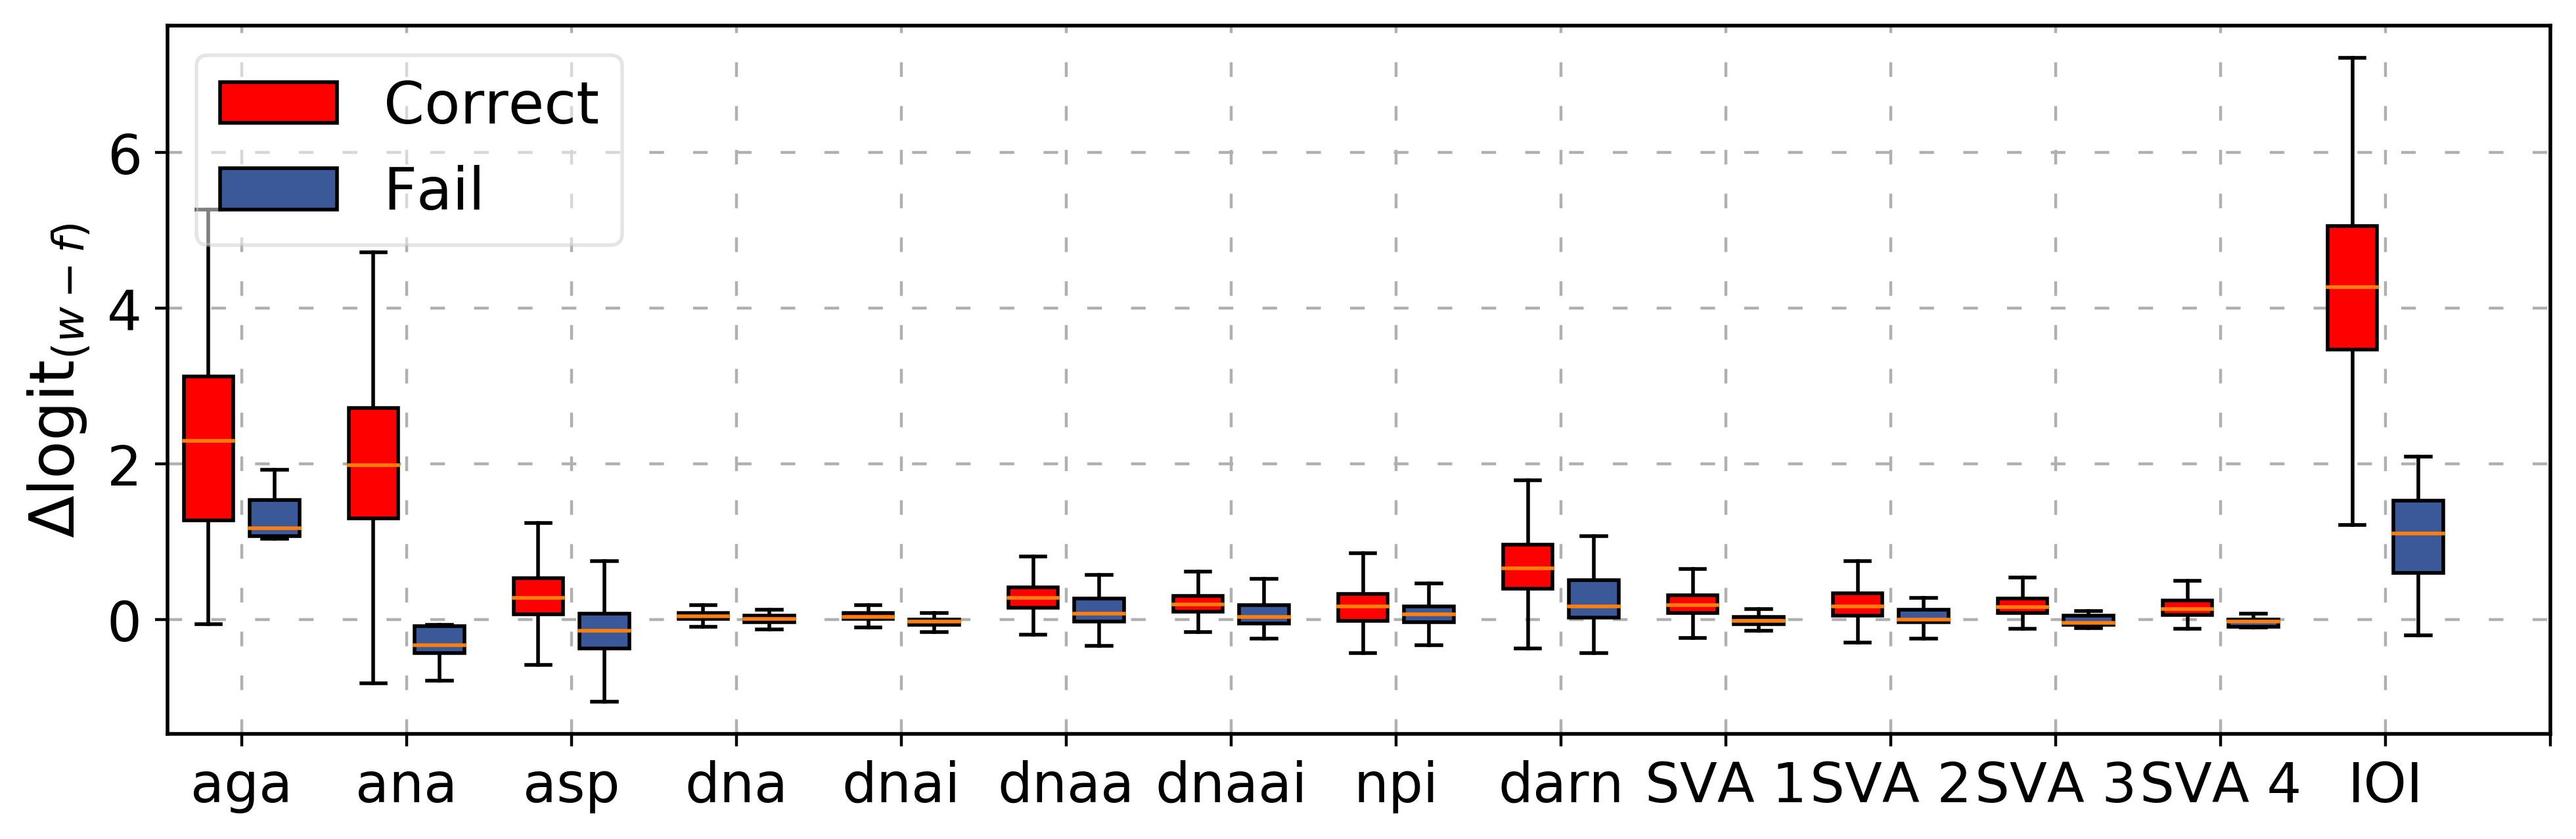

In [7]:
from matplotlib.transforms import Affine2D
from src.utils import task_to_abbr
fig, ax = plt.subplots(figsize=(11.7,3.5),dpi=400)#figsize=(10,3)

data_a = dict_dicts['corrects']['logit_attn_full_alti']
data_b = dict_dicts['fails']['logit_attn_full_alti']

#trans = Affine2D().translate(trans_list[i], 0.0) + ax.transData

labels, data = data_a.keys(), data_a.values()
bpl = ax.boxplot(data_a.values(), positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6, patch_artist=True)
for patch in bpl['boxes']:
        patch.set(facecolor='r')
bpr = ax.boxplot(data_b.values(), positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6, patch_artist=True)
for patch in bpr['boxes']:
        patch.set(facecolor='#3b5998')    
#plt.violinplot(data,showmedians=True)
ax.legend([bpl["boxes"][0], bpr["boxes"][0]], ['Correct', 'Fail'],prop={'size': 16},framealpha=0.5,loc='upper left')
plt.xticks(range(0, len(labels)*2 + 1, 2), [task_to_abbr[label] for label in labels])
#ax.set_title(f'{dataset_2_ling_name[subset]}: {model_2_label[name_path]}', size=17)
#ax.set_xlabel('Layer', size=17)
ax.set_ylabel(r'$\Delta \mathrm{logit}_{(w-f)}$', size=17)
ax.grid(True, linestyle=(0, (5, 10)));


In [285]:
# import os


# os.makedirs(f'./results/tables/{dataset}/', exist_ok = True)
# df_results.transpose().to_csv(f'results/tables/{dataset}/{name_path}_{metric}.csv')

# df_results_ranks.transpose().to_csv(f'results/tables/{dataset}/{name_path}_{metric}_ranks.csv')

# Read results

In [33]:
from src.utils import task_to_abbr, dataset_2_ling_name
metric = 'mrr'
dataset = 'ioi'

dataset_2_label = {'blimp' : 'BLiMP',
                    'sva': 'SVA',
                    'ioi': 'IOI',
                    'sva_1': 'SVA1',
                    'sva_2': 'SVA2',
                    'sva_3': 'SVA3',
                    'sva_4': 'SVA4'}

model_2_label = {'gpt2': 'GPT-2 Small',
                    'gpt2-large': 'GPT-2 Large',
                    'gpt2-xl': 'GPT-2 XL',
                    'facebook-opt-125m': 'OPT 125M',
                    'bigscience-bloom-560m': 'BLOOM 560M',
                    'bigscience-bloom-1b1': 'BLOOM 1B1'

}
labels = ['Random', 'Grad Norm', r'G$\times$I', 'Erasure', 'Logit', 'ALTI-Logit']
color = ['#82B366', '#6C8EBF','#D79B00','#5C5C5C', '#E9967A', '#C15252']

method_name_to_clean_name = {
    'random':'Random',
    'grad_norm_2' :'Grad Norm',
    'grad_inp_2' :r'G$\times$I',
    'erasure' : 'Erasure',
    'logit_attn_simp': 'Linear Logit',
    'logit_attn_full': 'Logit',
    'logit_attn_simp_alti': 'Linear Logit ALTI',
    'logit_attn_full_alti': 'ALTI Logit'
}
if name_path == 'gpt2-xl':
    num_layers = 48
elif name_path == 'gpt2':
    num_layers = 12


In [70]:
name_path = 'gpt2-large'
methods = ['erasure', 'logit_attn_full', 'logit_attn_full_alti', 'grad_norm_2', 'grad_inp_2', 'random']

df = pd.read_csv(f'./results/tables/all_datasets/{name_path}_{metric}.csv', index_col=0)[methods]
def change_index(dataset_):
    return task_to_abbr[dataset_]

df.index = df.index.map(lambda x: change_index(x))
df.to_csv(f'./results/paper_{name_path}.csv')

In [71]:
df

erasure  logit_attn_full  logit_attn_full_alti  grad_norm_2  \
aga      0.969            0.800                 0.964        0.721   
ana      0.934            0.810                 0.943        0.723   
asp      0.492            0.368                 0.585        0.681   
dna      0.352            0.671                 0.530        0.240   
dnai     0.377            0.585                 0.490        0.251   
dnaa     0.608            0.932                 0.514        0.201   
dnaai    0.645            0.875                 0.440        0.201   
npi      0.755            0.584                 0.657        0.860   
darn     0.558            0.881                 0.957        0.669   
SVA 1    0.381            0.608                 0.687        0.422   
SVA 2    0.439            0.646                 0.705        0.482   
SVA 3    0.449            0.500                 0.672        0.557   
SVA 4    0.377            0.486                 0.610        0.508   
IOI      0.599            1.000                 1.000        0.822   

       grad_inp_2  random  
aga         0.698   0.688  
ana         0.671   0.708  
asp         0.427   0.374  
dna         0.500   0.464  
dnai        0.483   0.449  
dnaa        0.387   0.434  
dnaai       0.376   0.407  
npi         0.617   0.604  
darn        0.487   0.490  
SVA 1       0.380   0.328  
SVA 2       0.353   0.302  
SVA 3       0.427   0.265  
SVA 4       0.309   0.215  
IOI         0.107   0.240

In [37]:
df_layers = pd.read_csv(f'./results/tables/all_datasets/{name_path}_{metric}.csv', index_col=0)[['logit_attn_full_layer_' + str(i) for i in range(num_layers)]+ ['random']]
#df_layers[['logit_attn_full', 'logit_attn_full_alti']]
df_layers.keys()

Index(['logit_attn_full_layer_0', 'logit_attn_full_layer_1',
       'logit_attn_full_layer_2', 'logit_attn_full_layer_3',
       'logit_attn_full_layer_4', 'logit_attn_full_layer_5',
       'logit_attn_full_layer_6', 'logit_attn_full_layer_7',
       'logit_attn_full_layer_8', 'logit_attn_full_layer_9',
       'logit_attn_full_layer_10', 'logit_attn_full_layer_11', 'random'],
      dtype='object')

NameError: name 'num_layers' is not defined

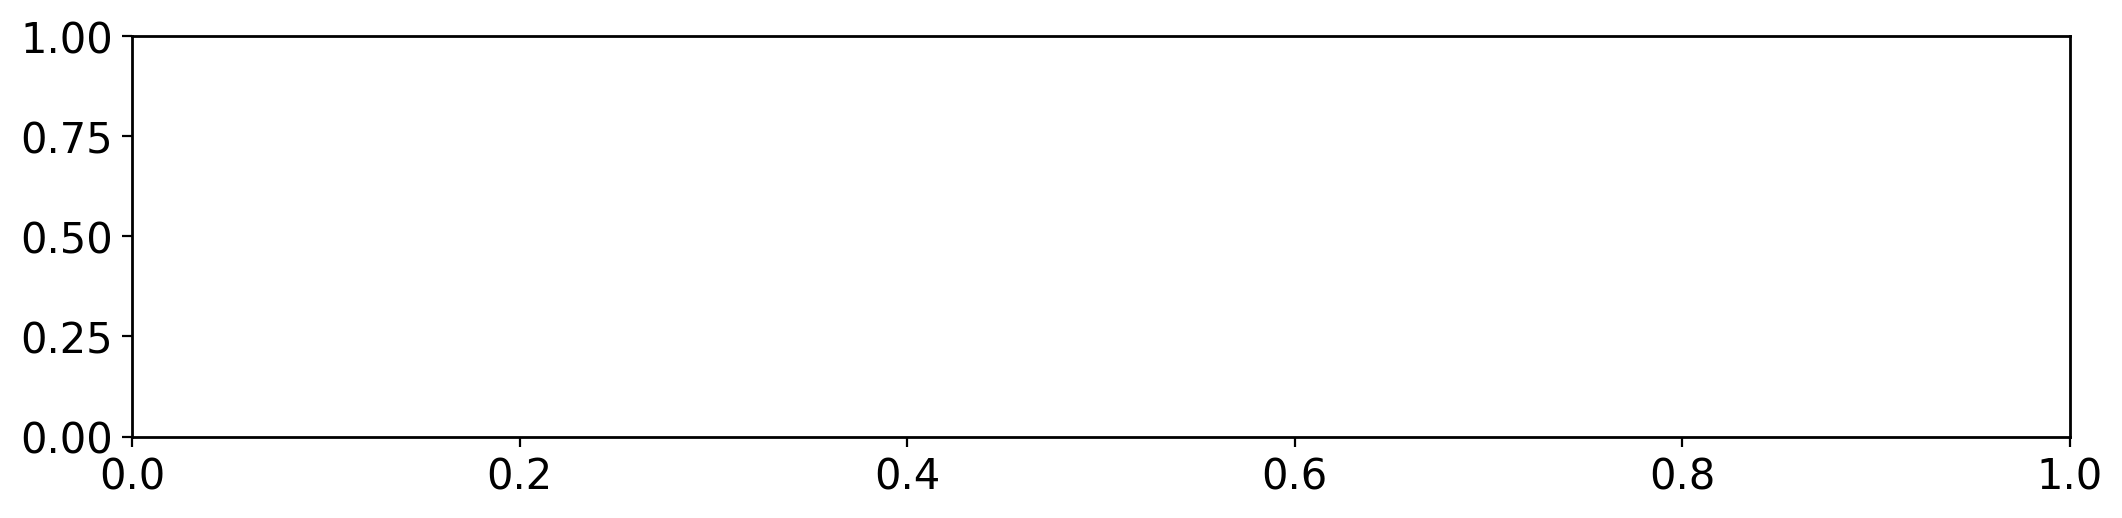

In [31]:
fig, ax = plt.subplots(figsize =(12.5, 2.6),dpi=200)
from matplotlib.ticker import FormatStrFormatter

name_path = 'gpt2'
metric = 'mrr'


subsets = ['distractor_agreement_relational_noun']
method = 'logit_attn_full_alti'
#subsets_list = list(pd.read_csv(f'./results/{dataset}/layerwise_{metric}_{name_path}.csv')['Unnamed: 0'])
df_layers = pd.read_csv(f'./results/tables/all_datasets/{name_path}_{metric}.csv', index_col=0)[[f'{method}_layer_' + str(i) for i in range(num_layers)]+ ['random']]
df_layers = df_layers.transpose()
random_values = df_layers.loc['random']
#df.columns = subsets_list
random_vals = df_layers[subsets].loc['random']
df_layers = df_layers.drop('random')
for j, subset in enumerate(subsets):
    random_val = random_vals[subset]
    p = plt.plot(np.arange(1,num_layers+1), df_layers[subset], label = task_to_abbr[subset])
    color = p[0].get_color()
    plt.axhline(y=random_val, linestyle='--', c=color)

if 'anaphor_gender_agreement' in subsets:
    ax.set_ylim(0.5,1.09)
elif 'determiner_noun_agreement_1' in subsets:
    ax.set_ylim(0.35,1.2)
elif 'ioi' in subsets:
    ax.set_ylim(0.0,1.02)

if name_path == 'gpt2':
    k = 3
    size_x_ticks = 13
elif name_path == 'gpt2-xl':
    k = 8
    size_x_ticks = 10.5
top_k_layers = np.argpartition(np.array(df_layers[subset]), -k)[-k:]+1
ax.set_xticks(top_k_layers)
ax.set_xticklabels(top_k_layers, rotation=0, size=size_x_ticks)# np.arange(1,num_layers+1)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.legend(prop={'size': 16},framealpha=0.5,loc='upper left')
ax.set_title(f'{dataset_2_ling_name[subset]}: {model_2_label[name_path]}', size=17)
ax.set_xlabel('Layer', size=17)
ax.set_ylabel('MRR', size=17)
ax.grid(True, linestyle=(0, (5, 10)));

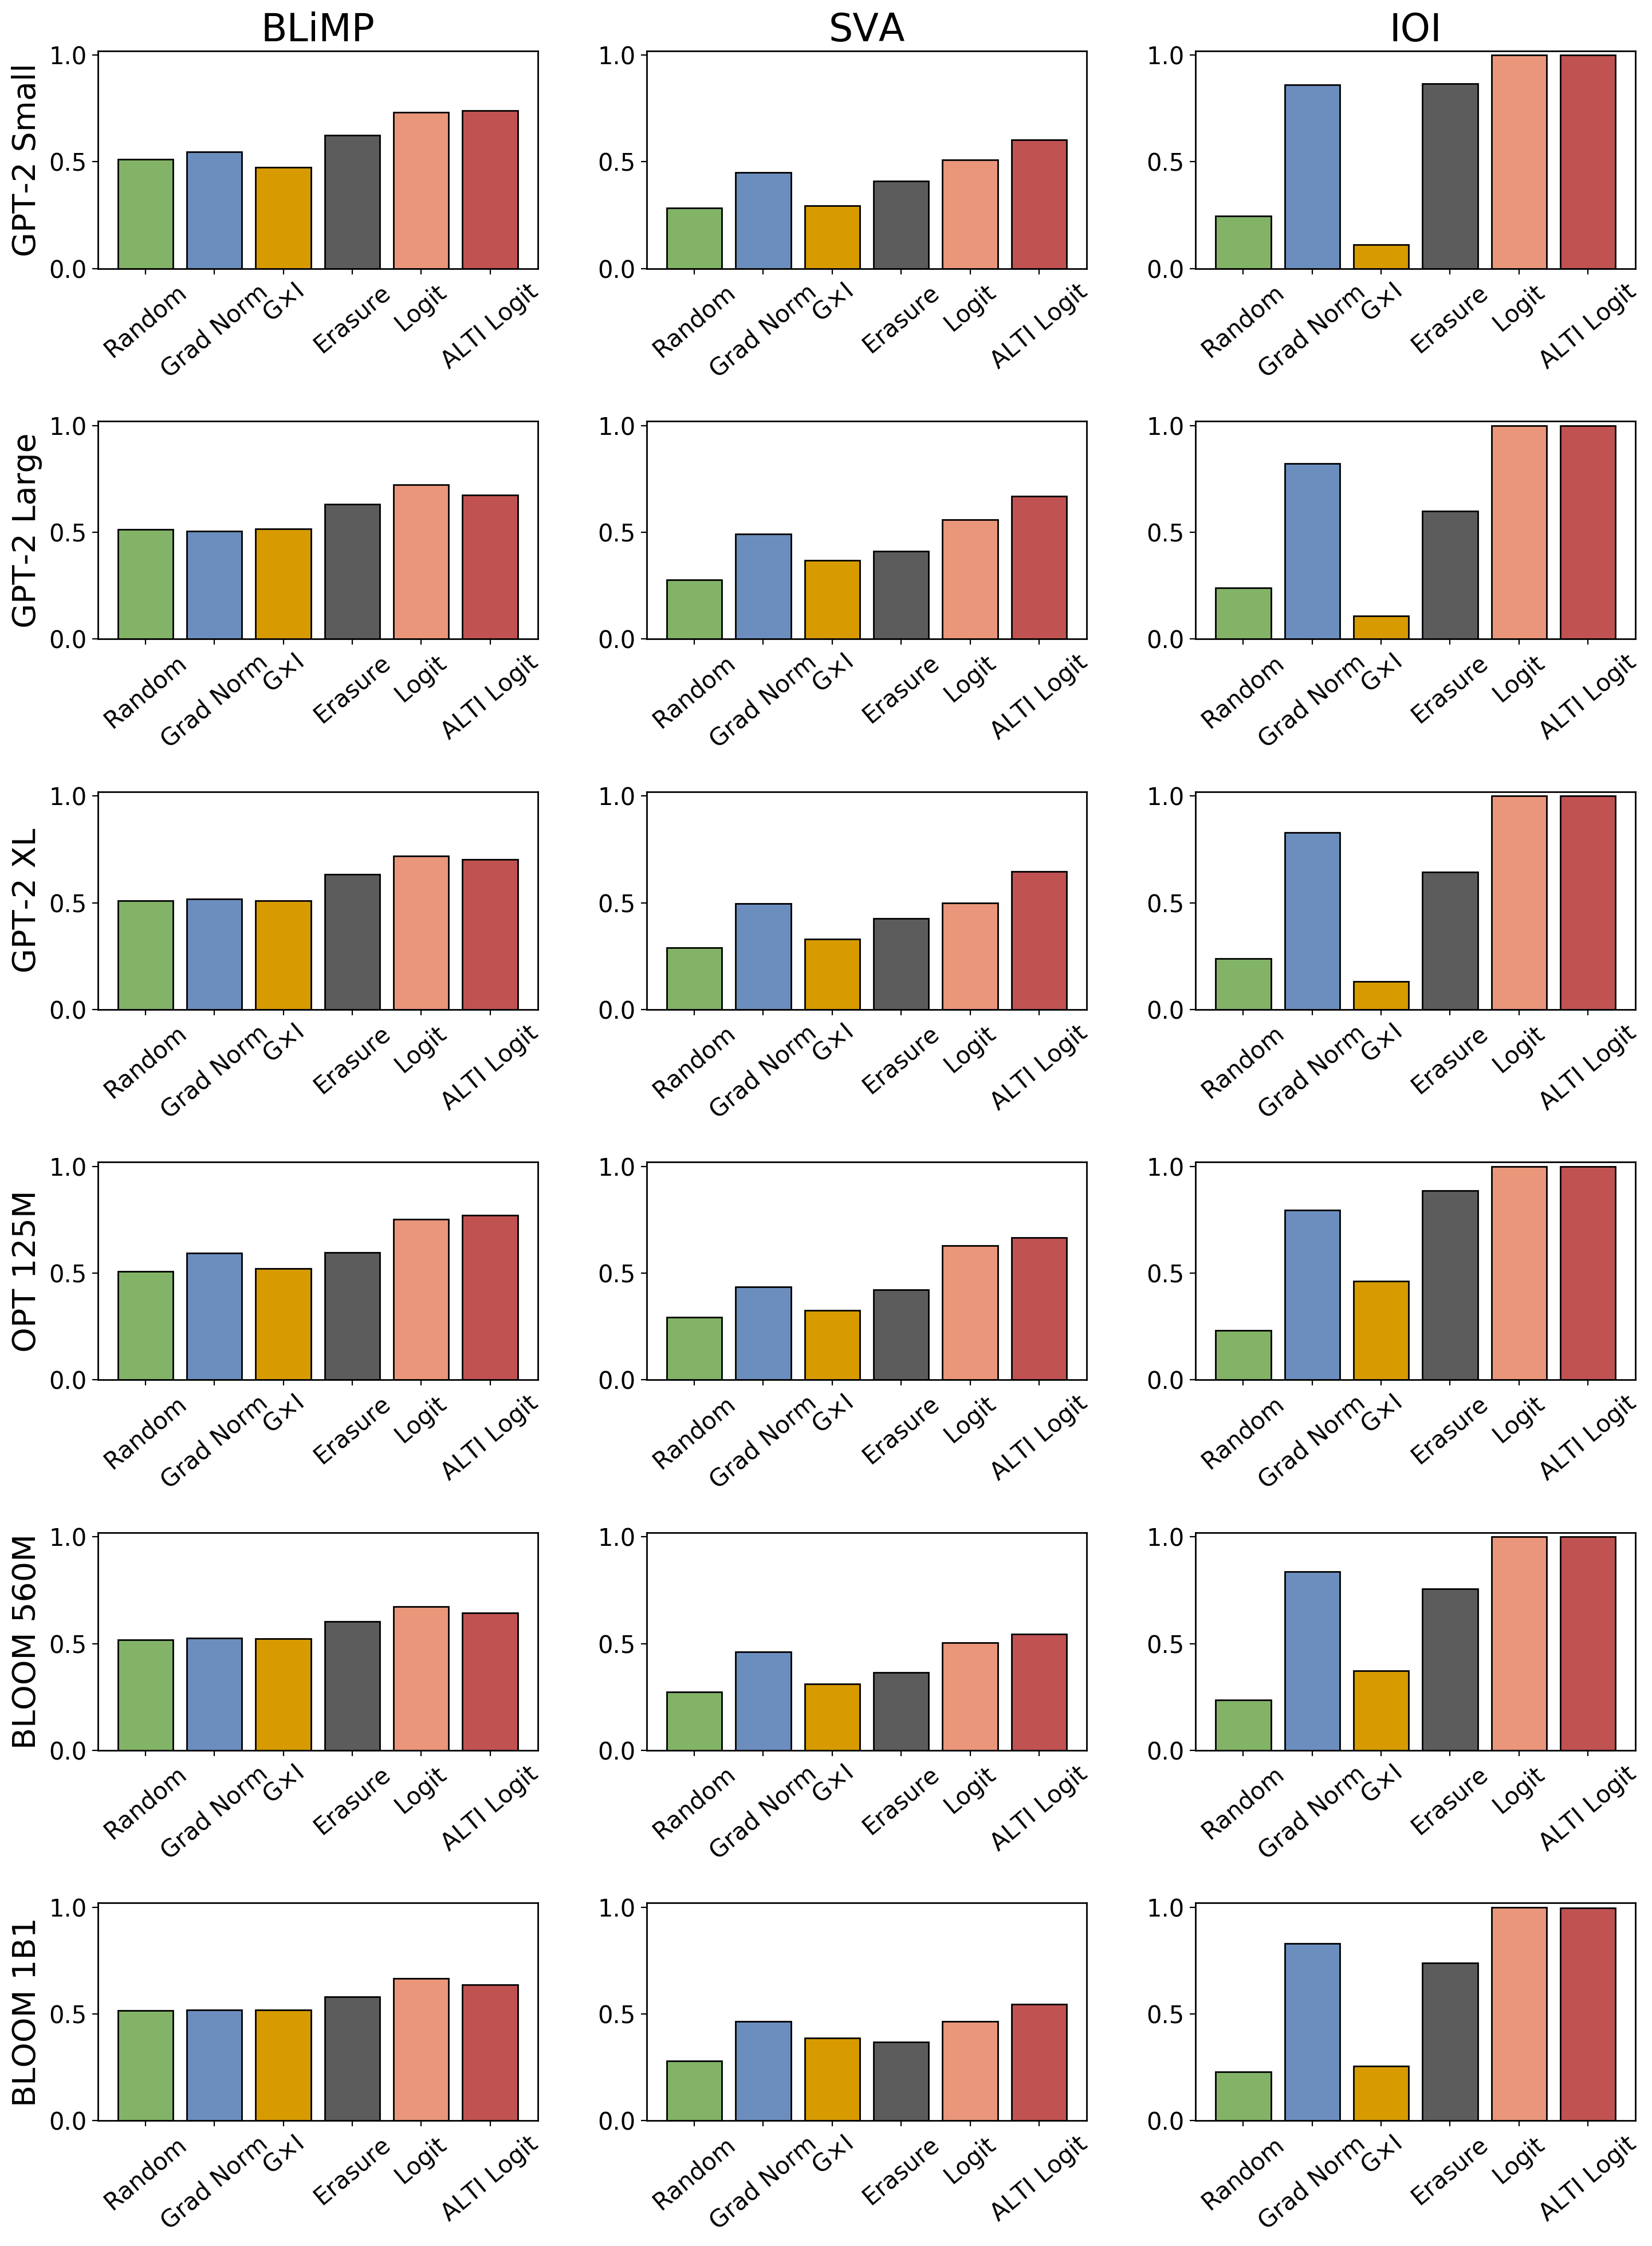

In [21]:
col = 3
row = 6

fig, axs = plt.subplots(row, col,figsize=(15,20), dpi=200,sharey=False)

metric = 'mrr'
methods = ['random', 'grad_norm_2', 'grad_inp_2', 'erasure', 'logit_attn_full', 'logit_attn_full_alti']

for row_num, name_path in enumerate(['gpt2', 'gpt2-large', 'gpt2-xl', 'facebook-opt-125m', 'bigscience-bloom-560m', 'bigscience-bloom-1b1']):
    name_path = name_path.replace('/','-')
    for col_num, dataset in enumerate(['blimp', 'sva', 'ioi']):
        df = pd.read_csv(f'./results/tables/all_datasets/{name_path}_{metric}.csv', index_col=0)
        if dataset == 'blimp':
            df = df[~((df.index.str.contains("sva")|(df.index.str.contains("ioi"))))]
        else:
            df = df[df.index.str.contains(dataset)]
        df_mean = df[methods].mean()
        axs[row_num,col_num].bar(range(len(df_mean)),df_mean.values, color=color, edgecolor='black')
        axs[row_num,col_num].set_xticks(range(0,len(df_mean)))
        axs[row_num,col_num].set_xticklabels([method_name_to_clean_name[m] for m in methods], rotation=40)
        if metric == 'mrr':
            axs[row_num,col_num].set_ylim(0.0,1.02)
        elif metric == 'probes':
            if col_num == 0:
                max_height = 2.52
            elif col_num == 1:
                max_height = 8.02
            elif col_num == 2:
                max_height = 14.02
            #axs[row_num,col_num].set_yticks(np.arange(0,max_height,0.5))
            axs[row_num,col_num].set_ylim(0.0,max_height)
        if col_num == 0:
            axs[row_num,col_num].set_ylabel(model_2_label[name_path])
        if row_num == 0:
            axs[row_num,col_num].set_title(dataset_2_label[dataset])
fig.tight_layout()


In [21]:
df_correct = pd.read_csv(f'./results/tables/all_datasets/correct_{name_path}_{metric}.csv', index_col=0)
df_fail = pd.read_csv(f'./results/tables/all_datasets/fail_{name_path}_{metric}.csv', index_col=0)

df_correct.mean() - df_fail.mean()

erasure                     0.196071
logit_attn_full             0.202857
logit_attn_full_alti        0.241929
logit_attn_full_mlp_alti    0.243500
logit_attn_simp             0.153071
logit_attn_simp_alti        0.192143
logit_attn_simp_mlp_alti    0.243500
grad_norm                   0.002286
grad_inp                   -0.015214
grad_norm_2                -0.002714
grad_inp_2                 -0.105143
random                      0.004000
dtype: float64

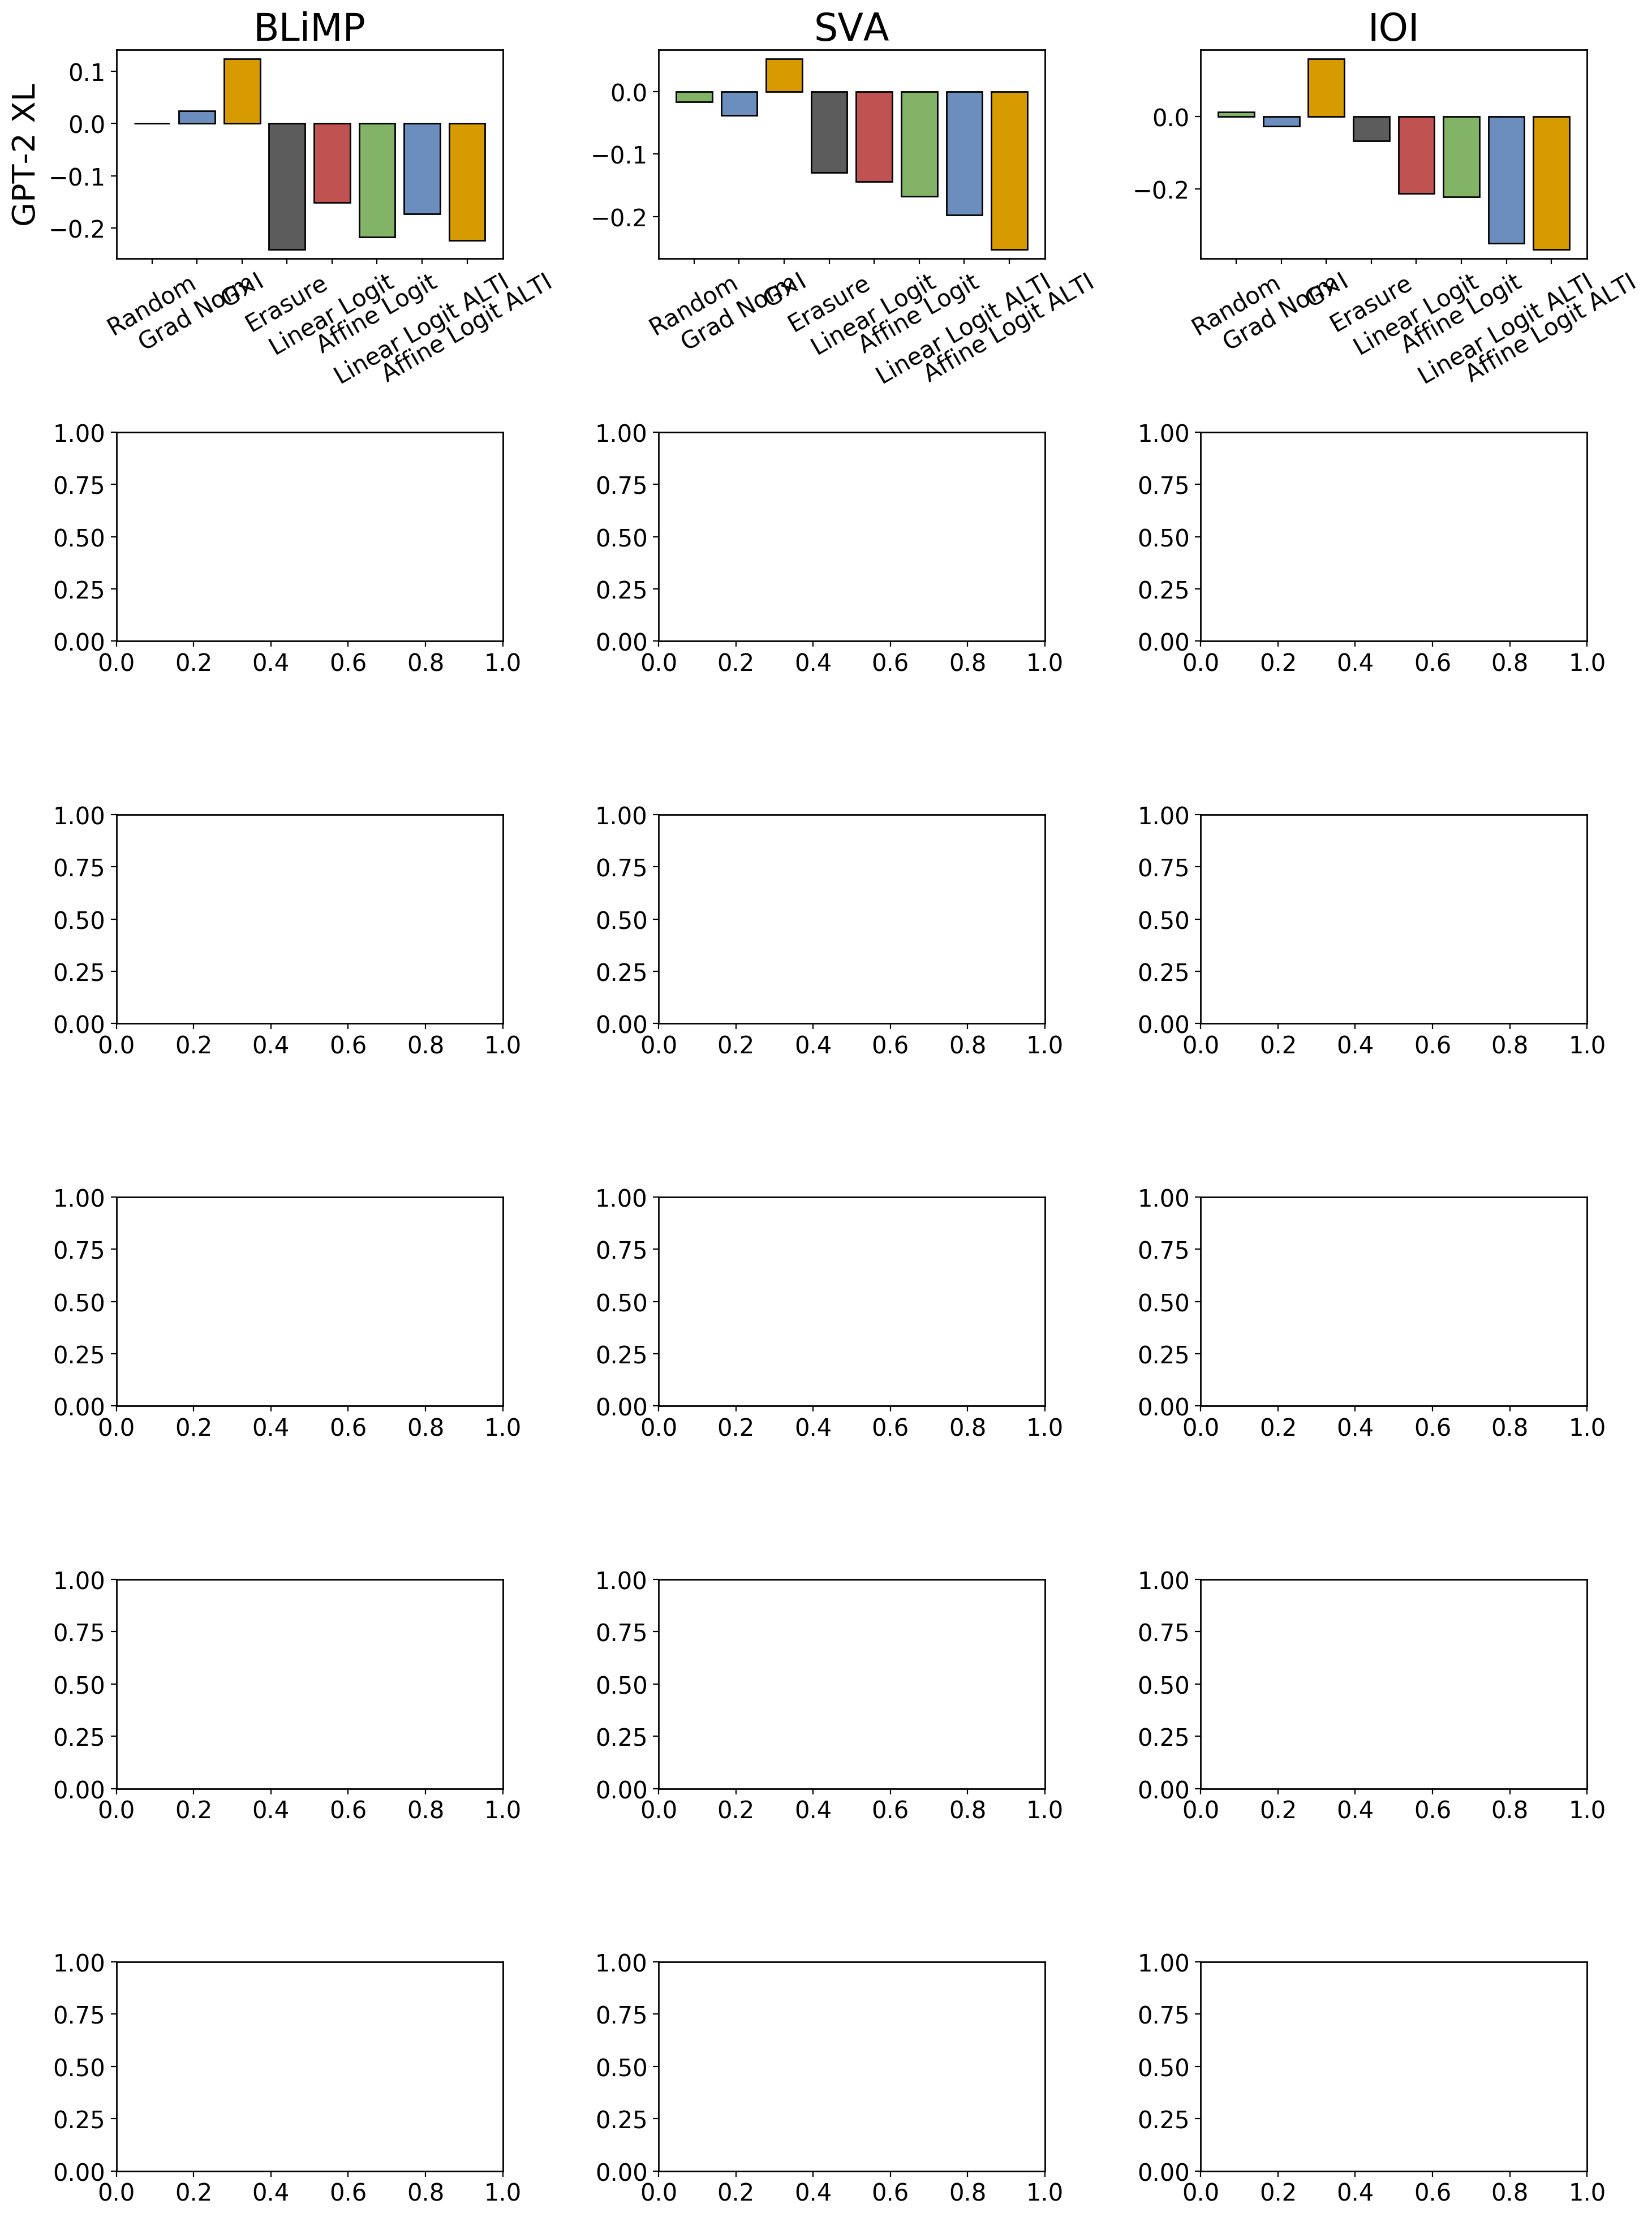

In [23]:
# Correct vs Fails
col = 3
row = 6

fig, axs = plt.subplots(row, col,figsize=(15,20), dpi=200,sharey=False)

metric = 'dot_product'
methods = ['random', 'grad_norm_2', 'grad_inp_2', 'erasure', 'logit_attn_simp', 'logit_attn_full', 'logit_attn_simp_alti', 'logit_attn_full_alti']
models = ['gpt2', 'gpt2-large', 'gpt2-xl', 'facebook-opt-125m', 'bigscience-bloom-560m', 'bigscience-bloom-1b1']
models = ['gpt2-xl']
for row_num, name_path in enumerate(models):
    name_path = name_path.replace('/','-')
    for col_num, dataset in enumerate(['blimp', 'sva', 'ioi']):
        df_correct = pd.read_csv(f'./results/tables/all_datasets/correct_{name_path}_{metric}.csv', index_col=0)
        df_fail = pd.read_csv(f'./results/tables/all_datasets/fail_{name_path}_{metric}.csv', index_col=0)
        if dataset == 'blimp':
            df_correct = df_correct[~((df_correct.index.str.contains("sva")|(df_correct.index.str.contains("ioi"))))]
            df_fail = df_fail[~((df_fail.index.str.contains("sva")|(df_fail.index.str.contains("ioi"))))]
        else:
            df_correct = df_correct[df_correct.index.str.contains(dataset)]
            df_fail = df_fail[df_fail.index.str.contains(dataset)]
        df_mean = df_fail[methods].mean() - df_correct[methods].mean()
        axs[row_num,col_num].bar(range(len(df_mean)),df_mean.values, color=color, edgecolor='black')
        axs[row_num,col_num].set_xticks(range(0,len(df_mean)))
        axs[row_num,col_num].set_xticklabels([method_name_to_clean_name[m] for m in methods], rotation=30)
        if metric == 'mrr':
            axs[row_num,col_num].set_ylim(-0.5,0.5)
        # elif metric == 'probes':
        #     if col_num == 0:
        #         max_height = 2.52
        #     elif col_num == 1:
        #         max_height = 8.02
        #     elif col_num == 2:
        #         max_height = 14.02
        #     #axs[row_num,col_num].set_yticks(np.arange(0,max_height,0.5))
        #     axs[row_num,col_num].set_ylim(0.0,max_height)
        if col_num == 0:
            axs[row_num,col_num].set_ylabel(model_2_label[name_path])
        if row_num == 0:
            axs[row_num,col_num].set_title(dataset_2_label[dataset])
fig.tight_layout()


In [ ]:
col = 3
row = 6

fig, axs = plt.subplots(row, col,figsize=(15,20), dpi=200,sharey=False)

metric = 'probes'

for row_num, name_path in enumerate(['gpt2-xl', 'gpt2-large', 'gpt2', 'facebook/opt-125m', 'bigscience/bloom-560m', 'bigscience/bloom-1b1']):
    name_path = name_path.replace('/','-')
    for col_num, dataset in enumerate(['blimp', 'sva', 'ioi']):
        df = pd.read_csv(f'./results/tables/{dataset}/{name_path}_{metric}.csv', index_col=0)
        if dataset == 'blimp':
            df = df[~((df.index.str.contains("sva")|(df.index.str.contains("ioi"))))]
        else:
            df = df[df.index.str.contains(dataset)]
        df_mean = df[['random', 'grad_norm_2', 'grad_inp_2', 'erasure', 'ours_contra']].mean()
        axs[row_num,col_num].bar(range(len(df_mean)),df_mean.values, color=color, edgecolor='black')
        axs[row_num,col_num].set_xticks(range(0,len(df_mean)))
        axs[row_num,col_num].set_xticklabels(labels, rotation=30)
        if metric == 'mrr':
            axs[row_num,col_num].set_ylim(0.0,1.02)
        elif metric == 'probes':
            if col_num == 0:
                max_height = 2.52
            elif col_num == 1:
                max_height = 8.02
            elif col_num == 2:
                max_height = 14.02
            #axs[row_num,col_num].set_yticks(np.arange(0,max_height,0.5))
            axs[row_num,col_num].set_ylim(0.0,max_height)
        if col_num == 0:
            axs[row_num,col_num].set_ylabel(model_2_label[name_path])
        if row_num == 0:
            axs[row_num,col_num].set_title(dataset_2_label[dataset])
fig.tight_layout()


In [11]:
labels

['Random', 'Grad Norm', 'G$\\times$I', 'Erasure', 'ALTI-Logit']

random                  0.512333
grad_norm_2             0.546444
grad_inp_2              0.475111
erasure                 0.625222
logit_attn_full         0.730667
logit_attn_full_alti    0.739111
dtype: float64

random                  0.28325
grad_norm_2             0.44900
grad_inp_2              0.29475
erasure                 0.40975
logit_attn_full         0.51025
logit_attn_full_alti    0.60400
dtype: float64

random                  0.245
grad_norm_2             0.860
grad_inp_2              0.111
erasure                 0.865
logit_attn_full         1.000
logit_attn_full_alti    1.000
dtype: float64

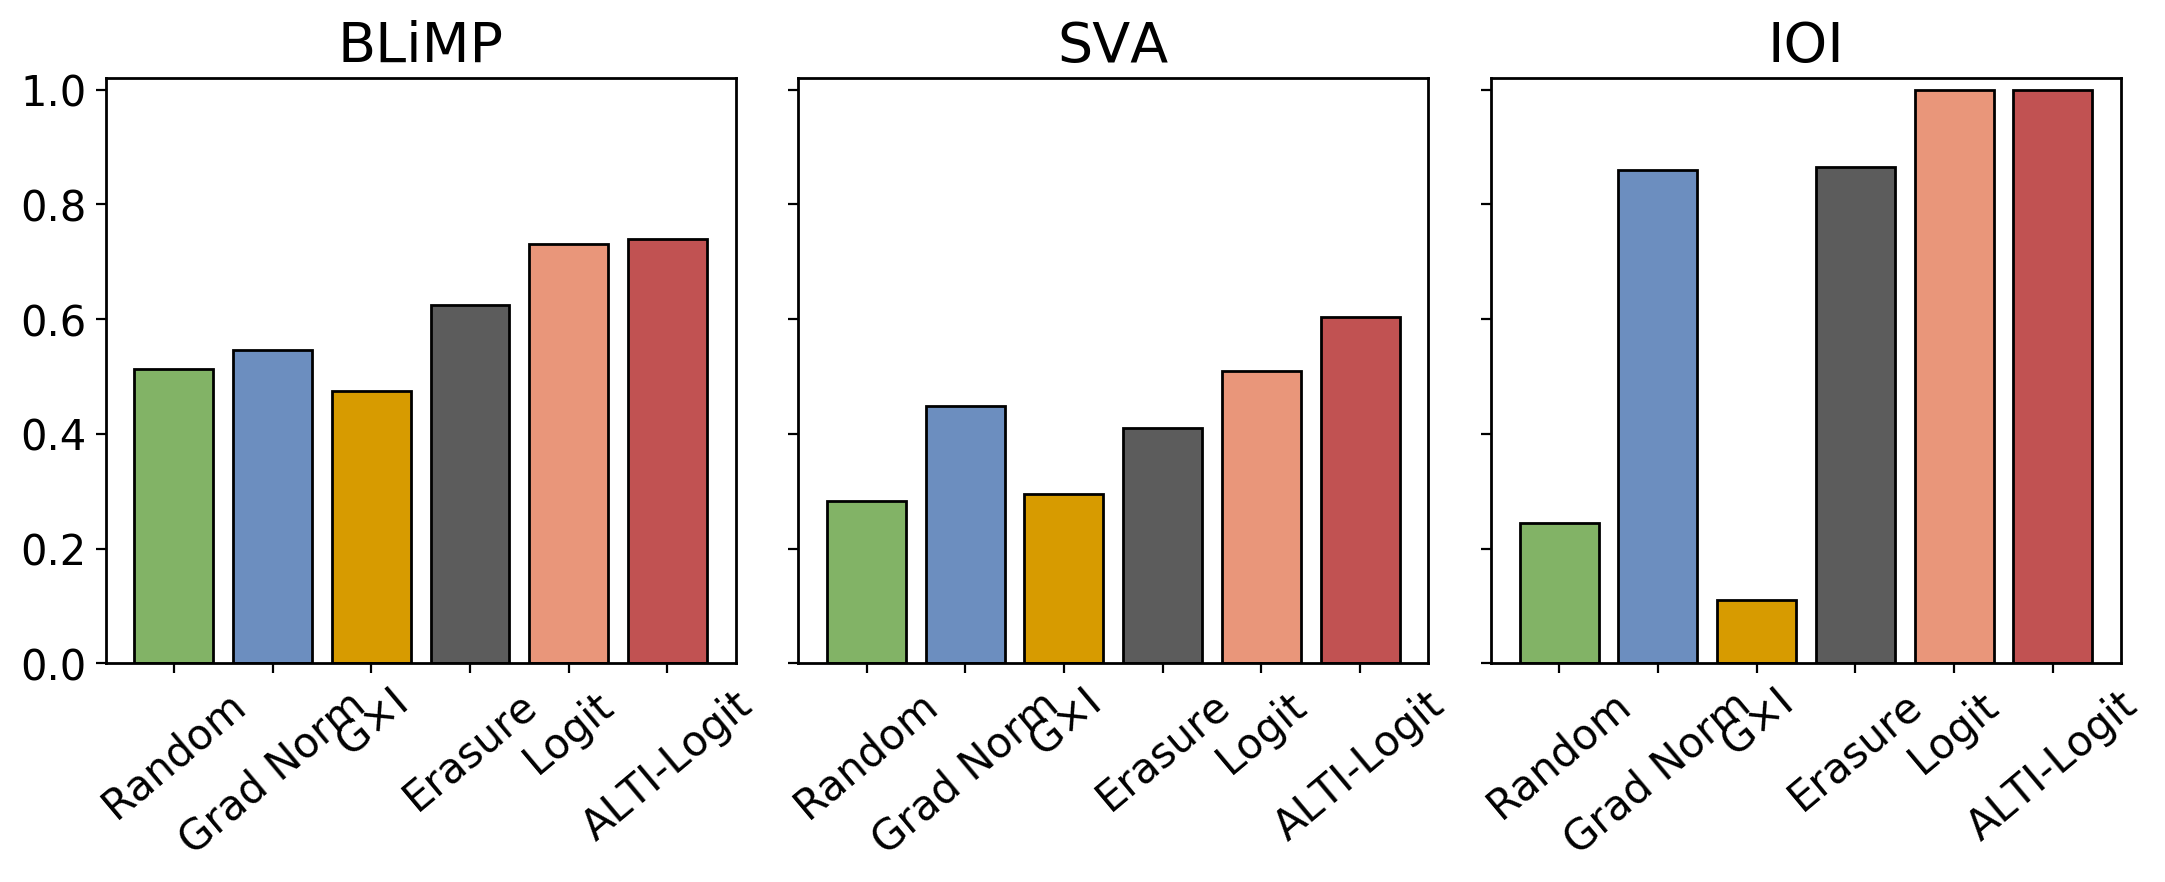

In [18]:


col = 3
row = 1

fig, axs = plt.subplots(row, col,figsize=(13,3.8), dpi=200,sharey=True)
plt.subplots_adjust(wspace=0.1)
metric = 'mrr'
methods = ['random', 'grad_norm_2', 'grad_inp_2', 'erasure', 'logit_attn_full', 'logit_attn_full_alti']
for row_num, name_path in enumerate(['gpt2']):
    for col_num, dataset in enumerate(['blimp', 'sva', 'ioi']):
        df = pd.read_csv(f'./results/tables/all_datasets/{name_path}_{metric}.csv', index_col=0)
        #df = pd.read_csv(f'./results/tables/{dataset}/{name_path}_{metric}.csv', index_col=0)
        if dataset == 'blimp':
            df = df[~((df.index.str.contains("sva")|(df.index.str.contains("ioi"))))]
        else:
            df = df[df.index.str.contains(dataset)]
        df_mean = df[methods].mean()
        display(df_mean)
        axs[col_num].bar(range(len(df_mean)),df_mean.values, color=color, edgecolor='black')
        axs[col_num].set_xticks(range(0,len(df_mean)))
        axs[col_num].set_xticklabels(labels, rotation=40)
        if metric == 'mrr':
            axs[col_num].set_ylim(0.0,1.02)
        elif metric == 'probes':
            if col_num == 0:
                max_height = 2.02
            elif col_num == 1:
                max_height = 8.02
            elif col_num == 2:
                max_height = 10.02
            #axs[row_num,col_num].set_yticks(np.arange(0,max_height,0.5))
            axs[col_num].set_ylim(0.0,max_height)
        # if col_num == 0:
        #     axs[col_num].set_ylabel(model_2_label[name_path],fontsize=18)# model_2_label[name_path]
        if row_num == 0:
            axs[col_num].set_title(dataset_2_label[dataset],fontsize=20)
#fig.tight_layout()


## Dataset analysis

In [ ]:
#name_path = 'facebook/opt-125m'
name_path = 'gpt2'
name_path = name_path.replace('/','-')
datasets = ['anaphor_gender_agreement',
        'anaphor_number_agreement',
        'animate_subject_passive',
        'determiner_noun_agreement_1',
        'determiner_noun_agreement_irregular_1',
        'determiner_noun_agreement_with_adjective_1',
        'determiner_noun_agreement_with_adj_irregular_1',
        'npi_present_1',
        'distractor_agreement_relational_noun',
        'ioi',
        'sva_1', 'sva_2', 'sva_3', 'sva_4']
#datasets = ['ioi']
#'sva_1', 'sva_2', 'sva_3', 'sva_4']

In [ ]:
name_path

'gpt2'

In [ ]:
import pickle
from collections import defaultdict
logits_diff_datasets = {}
logits_diff_datasets_layers = {}


for dataset in datasets:
    with open(f'./results/logits/{dataset}_{name_path}.pickle', 'rb') as handle:
        logits_file = pickle.load(handle)
    
    logits_diff_info = defaultdict(list)

    for idx in range(len(logits_file)):
        if logits_file[idx] == 'NA':
            continue
        logits_modules = logits_file[idx]
        # Logits check (should match logits computed by the model)
        
        total_logit_diff = logits_modules['correct_id_logit'] - logits_modules['foil_id_logit']
        logits_diff_info['total_logits_diff'].append(total_logit_diff)
        init_logit_token_a = logits_modules['init_logit'][0]
        mlp_logit_token_a = [logit_layer[0].item() for logit_layer in logits_modules['mlp_logit_layers']]
        total_mlp_logits_a = sum(mlp_logit_token_a)
        mlp_logit_token_b = [logit_layer[1].item() for logit_layer in logits_modules['mlp_logit_layers']]
        total_mlp_logits_b = sum(mlp_logit_token_b)
        #b_o_logit_token_a = [logit_layer[0].item() for logit_layer in logits_modules['b_o_logits_layers']]

        diff_total_mlp_logit = total_mlp_logits_a - total_mlp_logits_b
        logits_diff_info['total_logits_mlp_diff'].append(diff_total_mlp_logit)
        diff_mlp_logit_layers = list(np.array(mlp_logit_token_a) - np.array(mlp_logit_token_b))
        logits_diff_info['logits_diff_mlp_layers'].append(diff_mlp_logit_layers)
    logits_diff_datasets[dataset] = logits_diff_info


In [ ]:
# Percentage errors in datasets by model 
for dataset in datasets:
    logits_diff_dataset = np.array(logits_diff_datasets[dataset]['total_logits_diff'])
    ptg_dataset = (logits_diff_dataset<0).sum()/len(logits_diff_dataset)
    print(f'{dataset}: {ptg_dataset*100}%')

anaphor_gender_agreement: 4.2%
anaphor_number_agreement: 0.5%
animate_subject_passive: 25.3%
determiner_noun_agreement_1: 7.916181606519208%
determiner_noun_agreement_irregular_1: 17.037037037037038%
determiner_noun_agreement_with_adjective_1: 11.730545876887339%
determiner_noun_agreement_with_adj_irregular_1: 14.285714285714285%
npi_present_1: 28.1%
distractor_agreement_relational_noun: 10.201912858660998%
ioi: 4.1041041041041035%
sva_1: 14.572864321608039%
sva_2: 17.5%
sva_3: 19.0%
sva_4: 18.592964824120603%


In [ ]:
dataset_2_uid = {'anaphor_gender_agreement': 'aga',
 'anaphor_number_agreement': 'ana',
 'animate_subject_passive': 'asp',
 'determiner_noun_agreement_1': 'dna',
 'determiner_noun_agreement_irregular_1': 'dnai',
 'determiner_noun_agreement_with_adjective_1': 'dnaa',
 'determiner_noun_agreement_with_adj_irregular_1': 'dnaai',
 'npi_present_1': 'npi',
 'distractor_agreement_relational_noun': 'darn',
 'sva_1': 'SVA 1',
 'sva_2': 'SVA 2',
 'sva_3': 'SVA 3',
 'sva_4': 'SVA 4',
 'ioi': 'IOI'}

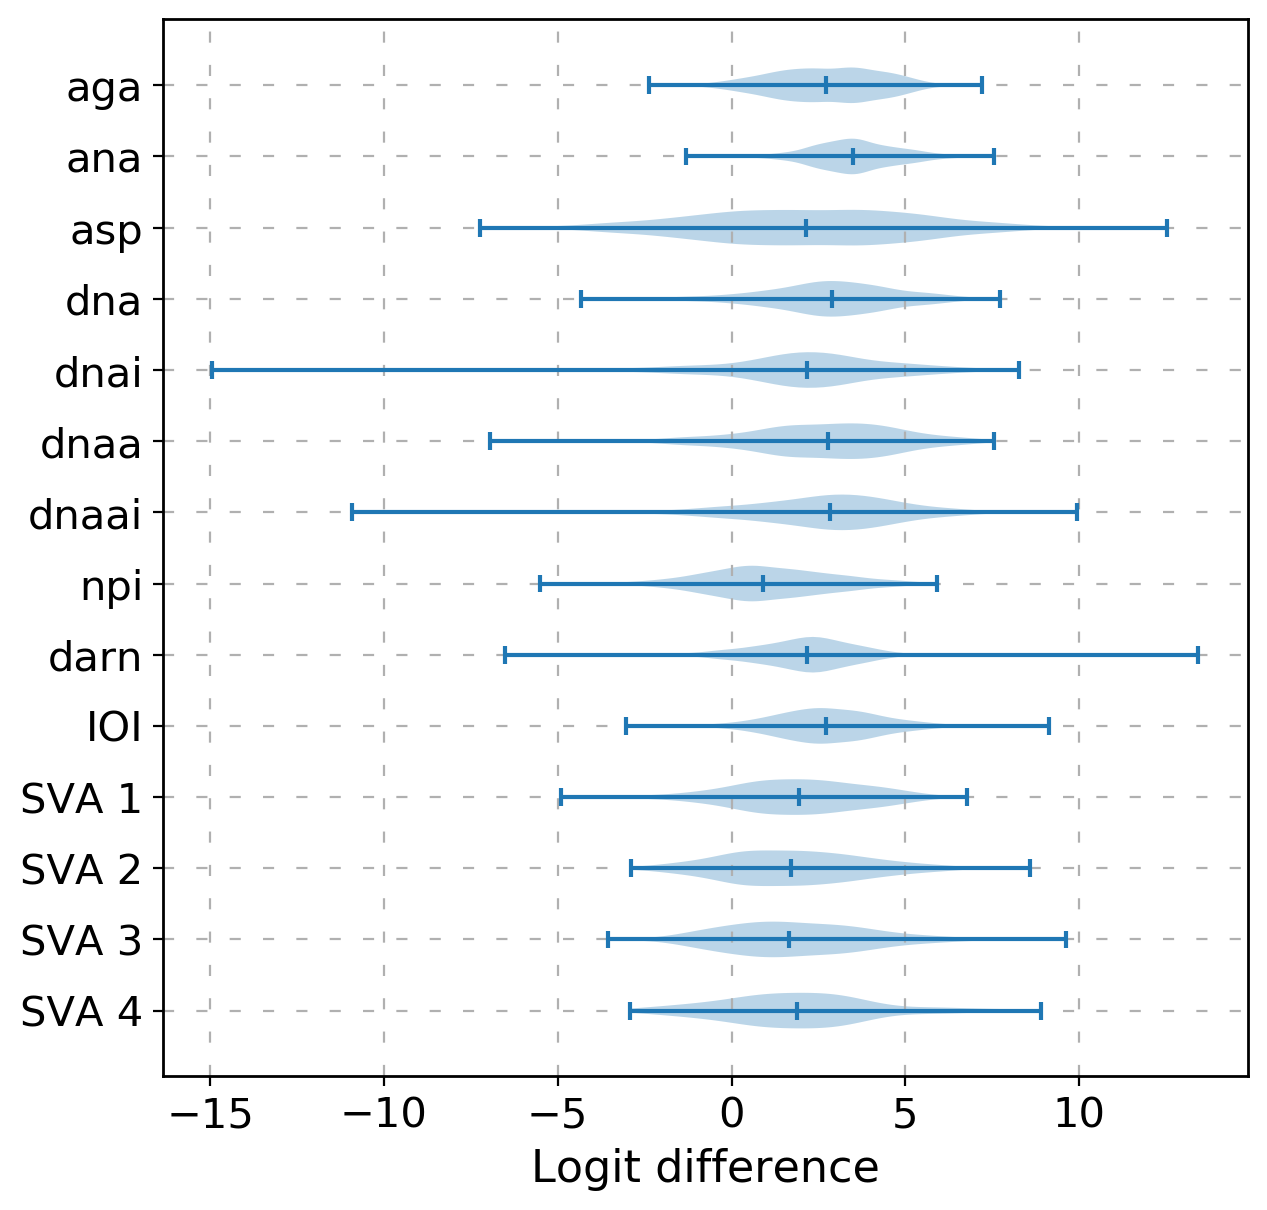

In [ ]:
from collections import OrderedDict
plot_dict = {}
selected_keys = logits_diff_datasets.keys()
# selected_keys = ['animate_subject_passive', 'npi_present_1', ]
# selected_keys = ['determiner_noun_agreement_1']
for key in selected_keys:
    plot_dict[key] = logits_diff_datasets[key]['total_logits_diff']

from collections import OrderedDict
# Reverse keys order to match paper's blimp subsets order
plot_dict = OrderedDict(reversed(list(plot_dict.items())))

fig, ax = plt.subplots(figsize =(7, 7),dpi=200) # figsize =(7, 6)

box = ax.violinplot(plot_dict.values(),positions=np.arange(0,len(plot_dict.keys()),1),# .values(), 
                    showmedians=True, vert=False)
counter = 0
ax.set_yticks(np.arange(0,len(plot_dict.keys()),1))
#ax.set_yticklabels(reversed(list(dataset_2_uid.values())), rotation=0)
ax.set_yticklabels([dataset_2_uid[key] for key in plot_dict.keys()], rotation=0)
ax.set_xlabel('Logit difference',fontsize=16)
#ax.set_ylim(0,1)
ax.grid(True, linestyle=(0, (5, 10)));
#plt.xlabel(r'Logit difference');

#logit_difference_gpt2_xl_npi_asp

In [ ]:
dataset = ['anaphor_gender_agreement',
'anaphor_number_agreement',
'animate_subject_passive',
'determiner_noun_agreement_1',
'determiner_noun_agreement_irregular_1',
'determiner_noun_agreement_with_adjective_1',
'determiner_noun_agreement_with_adj_irregular_1',
'npi_present_1',
'distractor_agreement_relational_noun',
'irregular_plural_subject_verb_agreement_1',
'regular_plural_subject_verb_agreement_1']
# 'sva_1', 'sva_2', 'sva_3', 'sva_4']
 
# Import library
import scipy.stats as stats


# Print the variance of both data groups
def flatten(l):
    return [item for sublist in l for item in sublist]


#separate_dataset = 'regular_plural_subject_verb_agreement_1'
for separate_dataset in dataset:
    group_dataset_results = []
    for key in logits_diff_datasets.keys():
        if key != separate_dataset:#'animate_subject_passive' and key != 'npi_present_1':
            group_dataset_results.append(logits_diff_datasets[key]['total_logits_diff'])
    #print(len(group_dataset_results))

    flat_group_dataset_results = flatten(group_dataset_results)
    print(separate_dataset)
    print(stats.ttest_ind(a=logits_diff_datasets[separate_dataset]['total_logits_diff'], b=flat_group_dataset_results, equal_var=False, alternative='less'))



anaphor_gender_agreement
Ttest_indResult(statistic=4.584640914648235, pvalue=0.9999975387620197)
anaphor_number_agreement
Ttest_indResult(statistic=24.520684007599456, pvalue=1.0)
animate_subject_passive
Ttest_indResult(statistic=-3.7829668606251383, pvalue=8.166256194363711e-05)
determiner_noun_agreement_1
Ttest_indResult(statistic=4.9121398717965175, pvalue=0.9999994811532615)
determiner_noun_agreement_irregular_1
Ttest_indResult(statistic=-6.243868244817442, pvalue=3.2812180583516645e-10)
determiner_noun_agreement_with_adjective_1
Ttest_indResult(statistic=1.5399991756340614, pvalue=0.9380660986666909)
determiner_noun_agreement_with_adj_irregular_1
Ttest_indResult(statistic=-0.48710398793208853, pvalue=0.31315158885555516)
npi_present_1
Ttest_indResult(statistic=-25.91456169592662, pvalue=1.2329185746343243e-120)
distractor_agreement_relational_noun
Ttest_indResult(statistic=-10.100925322607651, pvalue=1.676634293947644e-23)
irregular_plural_subject_verb_agreement_1
Ttest_indResult(

In [ ]:
import scipy.stats as stats


# Print the variance of both data groups
print(np.var(flat_group_dataset_results), np.var(logits_diff_datasets[separate_dataset]['total_logits_diff']))

4.887982050971587 2.891637173223425


In [ ]:
stats.ttest_ind(a=logits_diff_datasets[separate_dataset]['total_logits_diff'], b=flat_group_dataset_results, equal_var=False, alternative='less')

## Layer-wise analysis in explanations (ALTI)

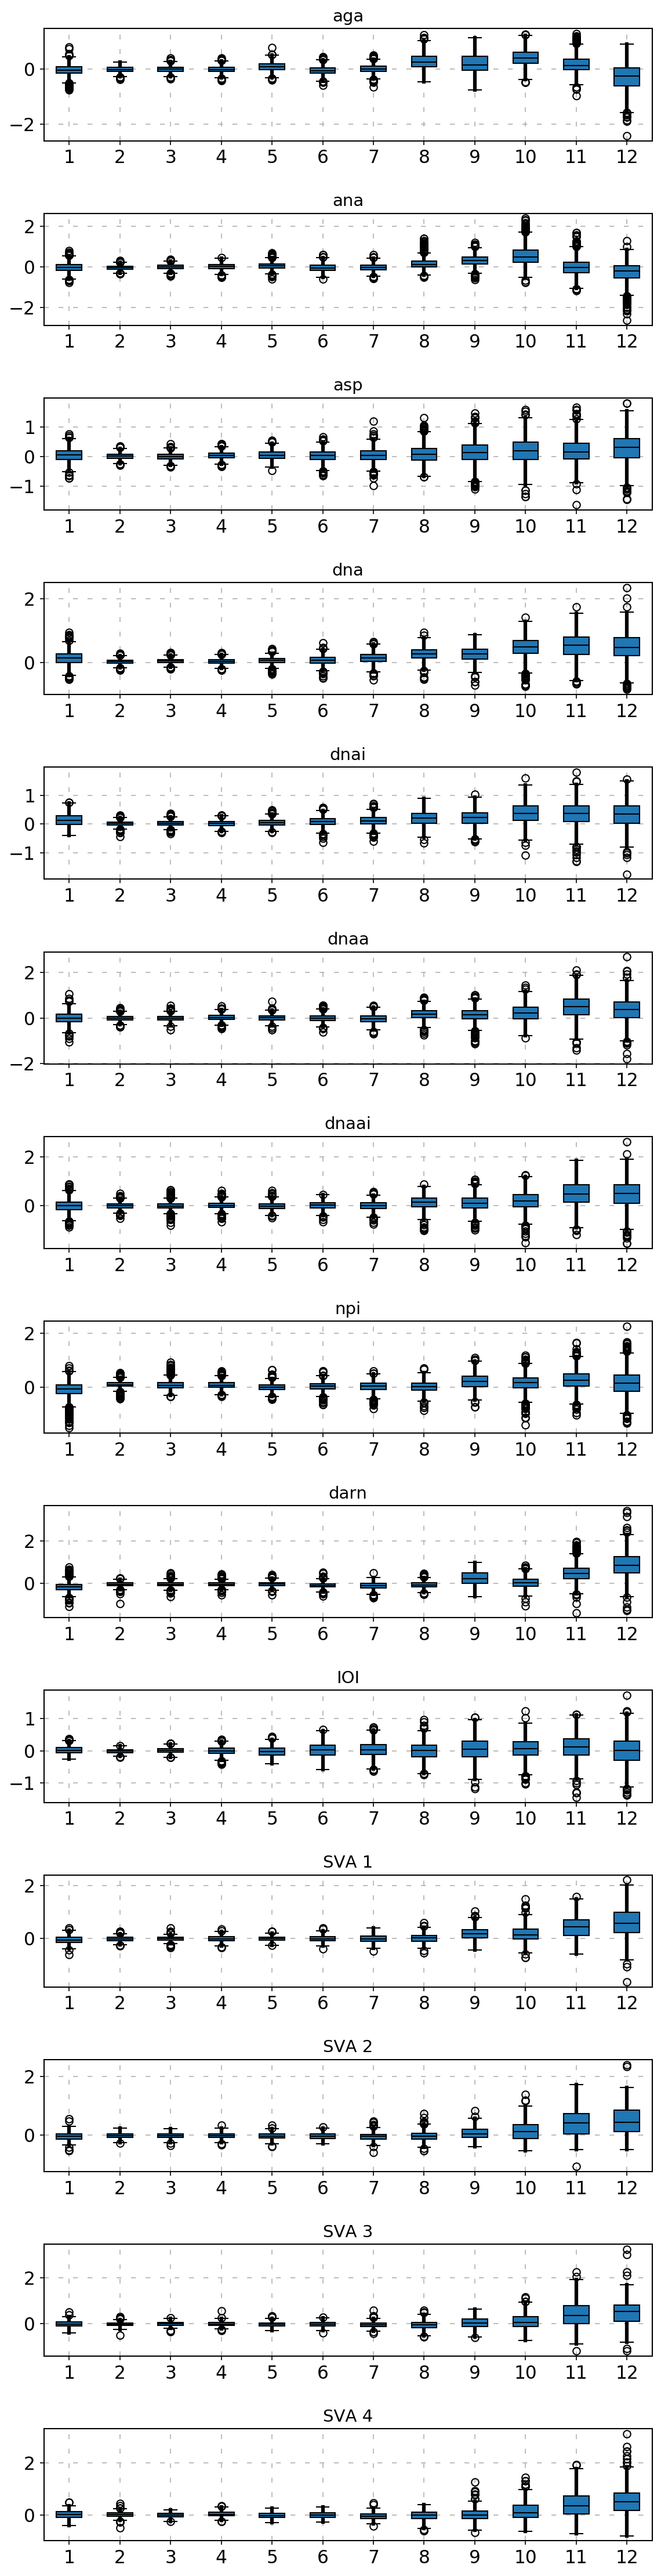

In [ ]:
import itertools
col = 1
row = len(logits_diff_datasets.keys())

fig, axs = plt.subplots(row, col,figsize=(8,30), dpi=150,sharey=False)

metric = 'probes'

for row_num, dataset in enumerate(logits_diff_datasets.keys()):
    name_path = name_path.replace('/','-')
    # npi_present_1
    l = logits_diff_datasets[dataset]['logits_diff_mlp_layers']

    # short circuits at shortest nested list if table is jagged:
    list(map(list, zip(*l)))

    # discards no data if jagged and fills short nested lists with None
    transposed_l = list(map(list, itertools.zip_longest(*l, fillvalue=None)))

    colors = ['#82B366','#6C8EBF','#D79B00','#C98177']
    box = axs[row_num].boxplot(transposed_l,whiskerprops=dict(linewidth=3.0),
                    patch_artist=True, showfliers=True)
    plt.setp(box['medians'], color='black')
    counter = 0
    # for i, patch in enumerate(box['boxes']):
    #     print(patch)
    #     patch.set_facecolor(colors[i])
    # ax.set_xticklabels(plot_dict.keys())
    #ax.set_ylim(0,1)
    axs[row_num].grid(True, linestyle=(0, (5, 10)));
    axs[row_num].set_title(dataset_2_uid[dataset], size=14)
    #axs[row_num].set_xlabel('Layer', fontsize=16);
fig.tight_layout()


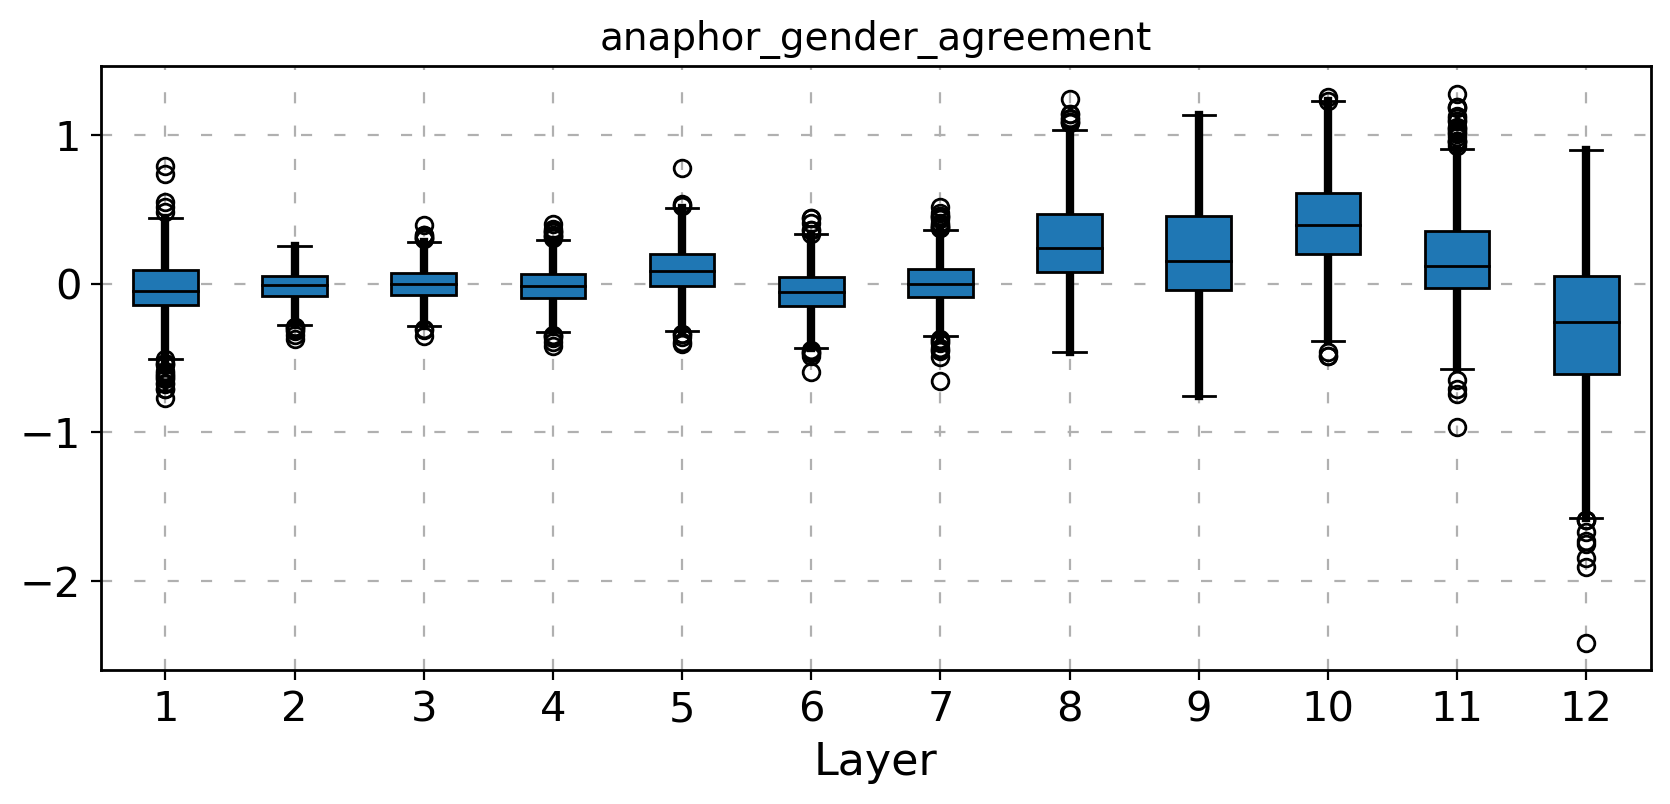

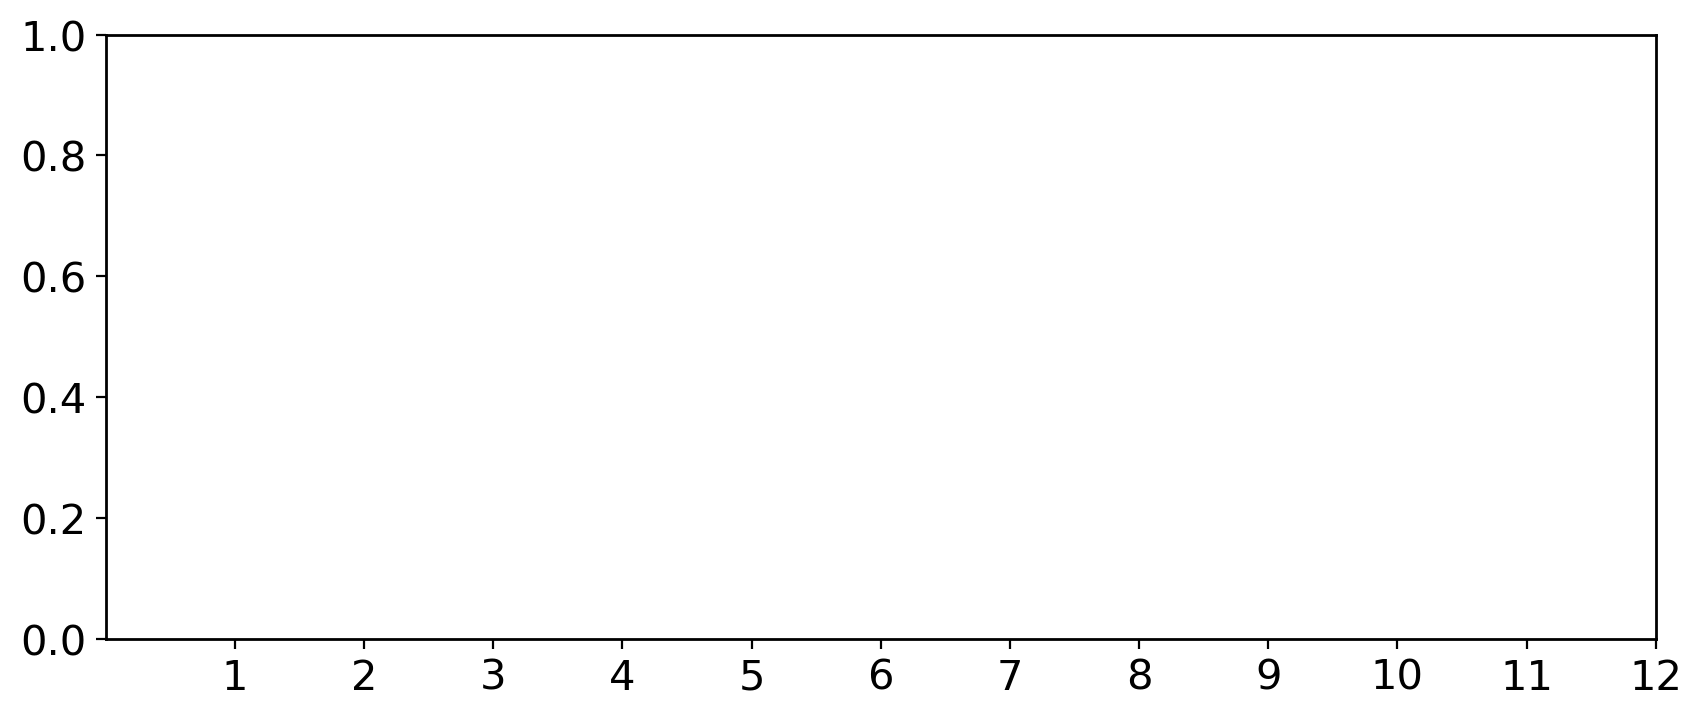

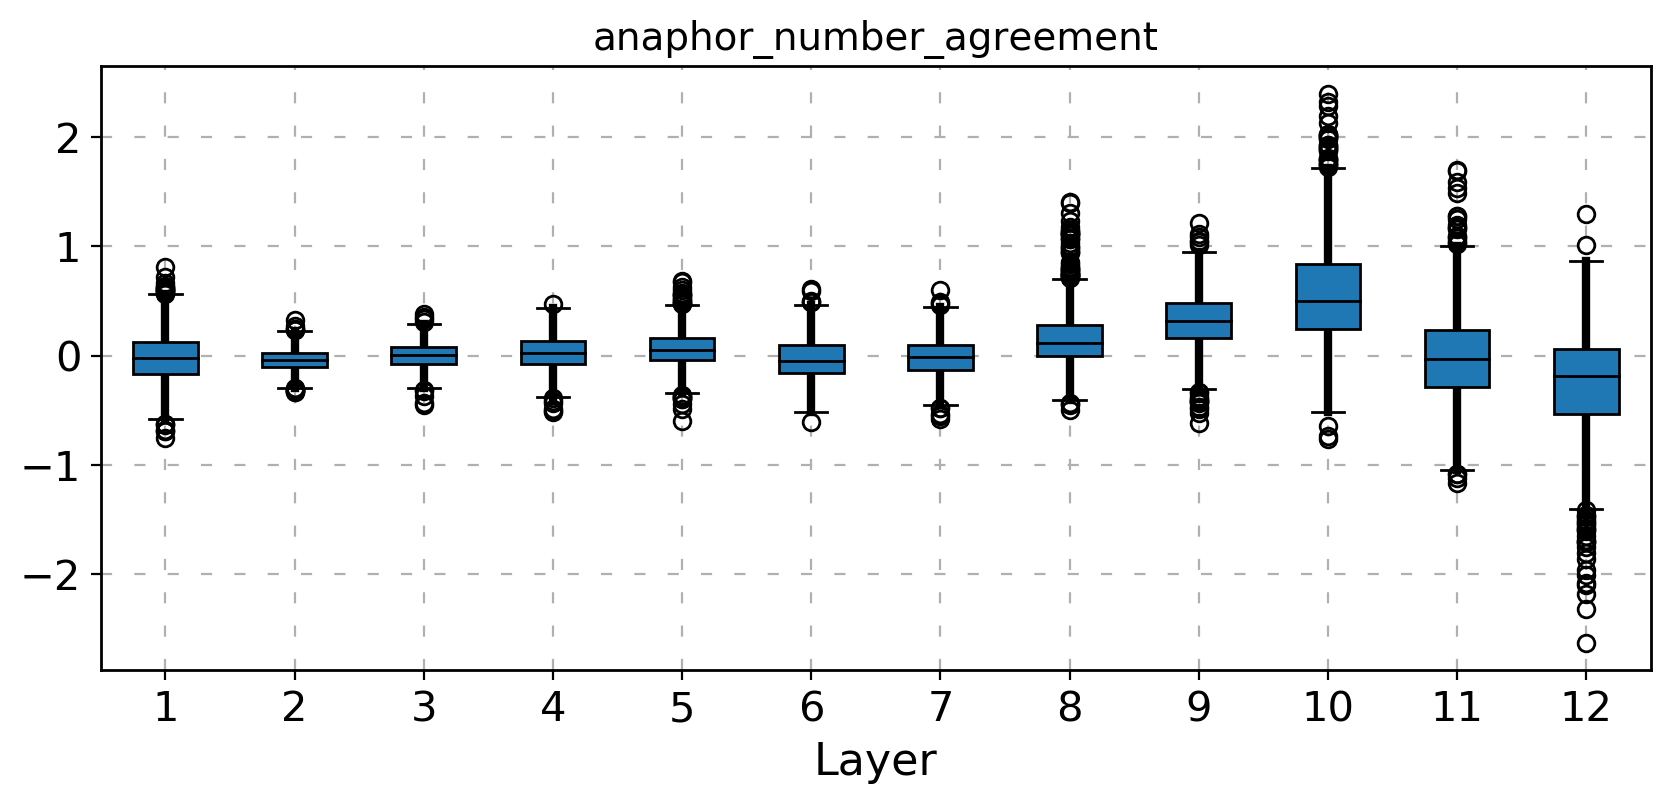

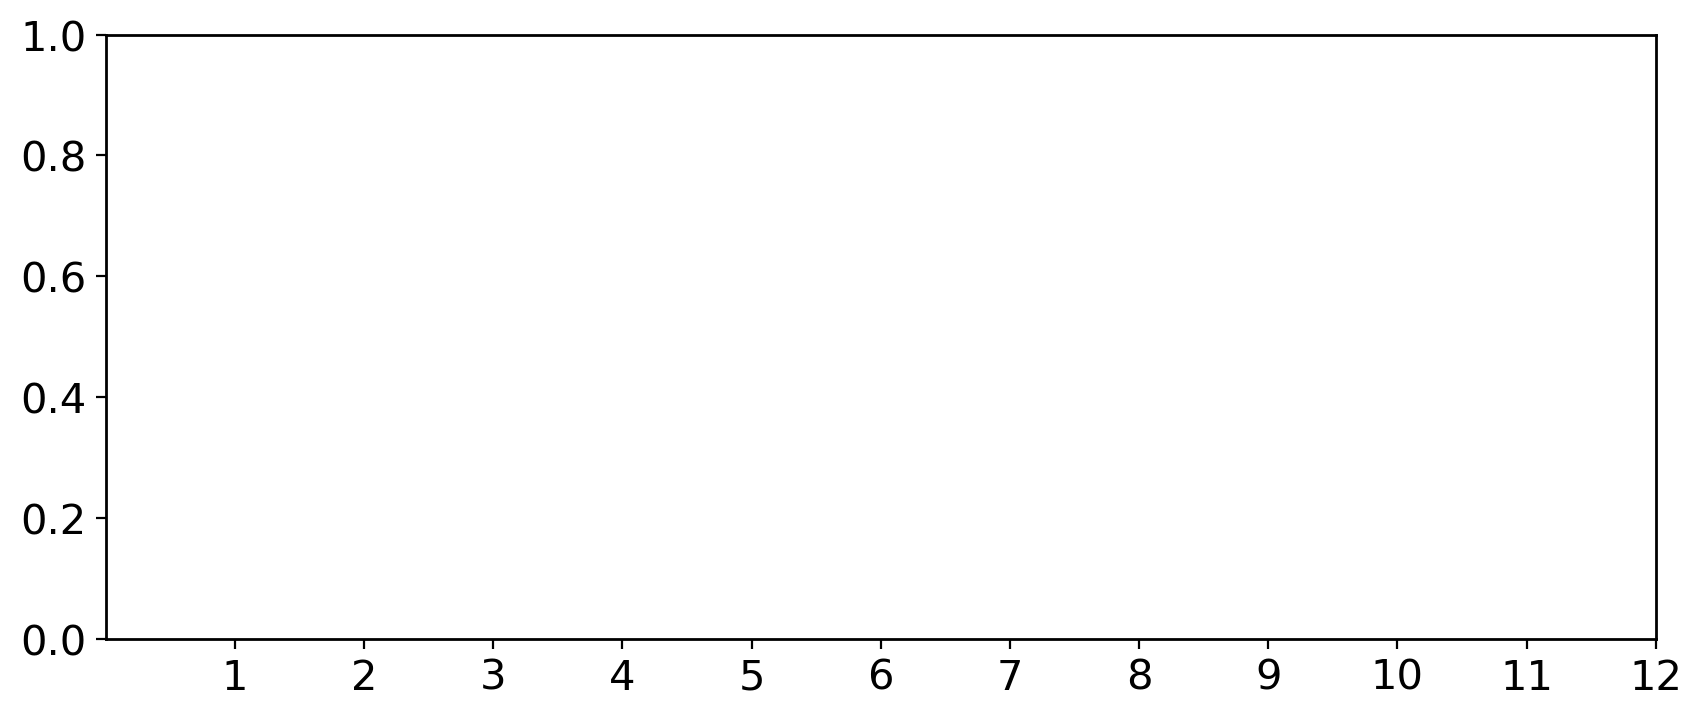

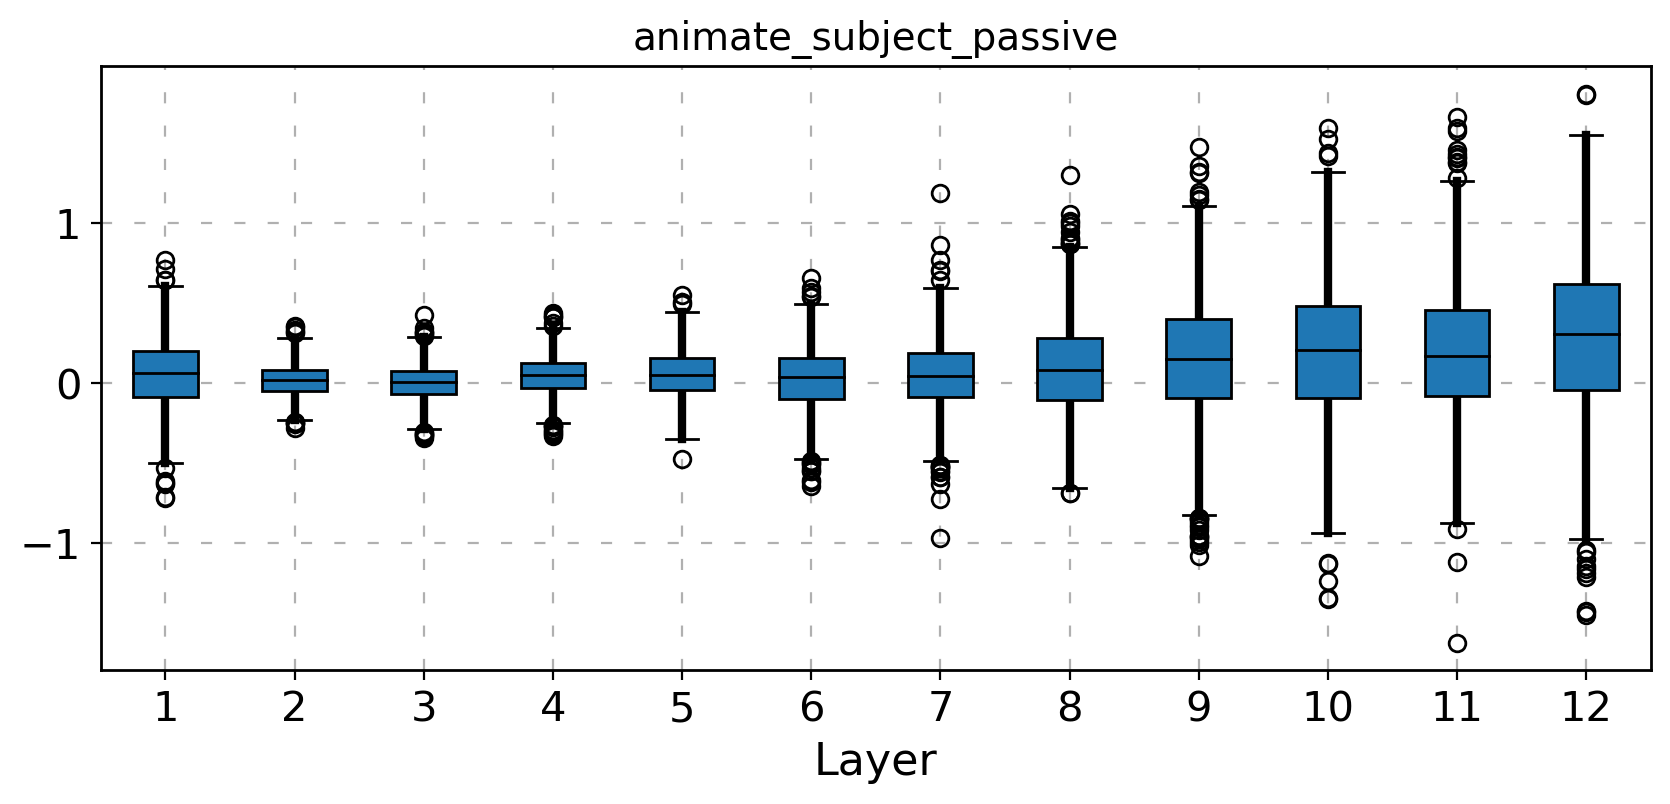

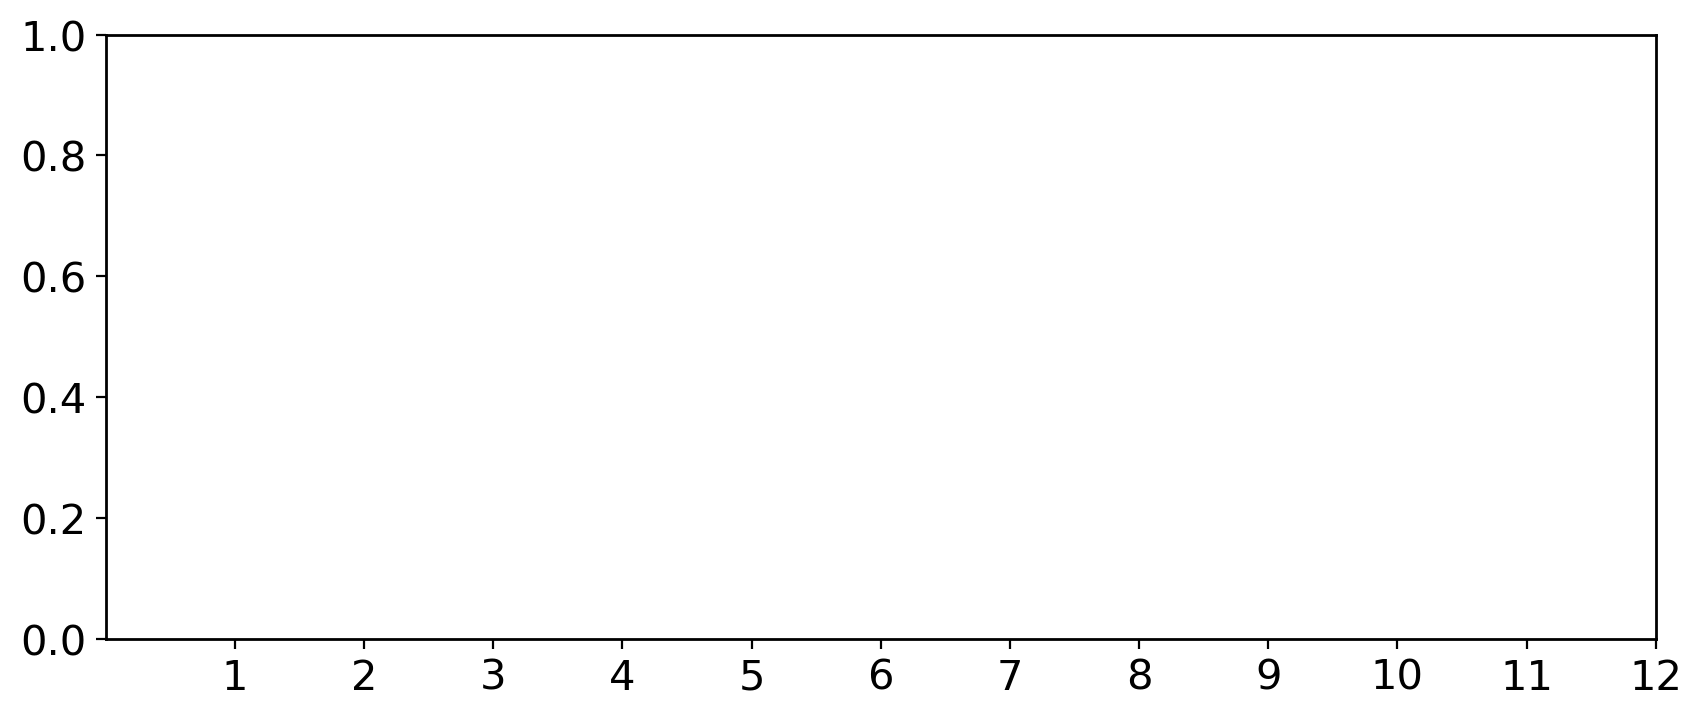

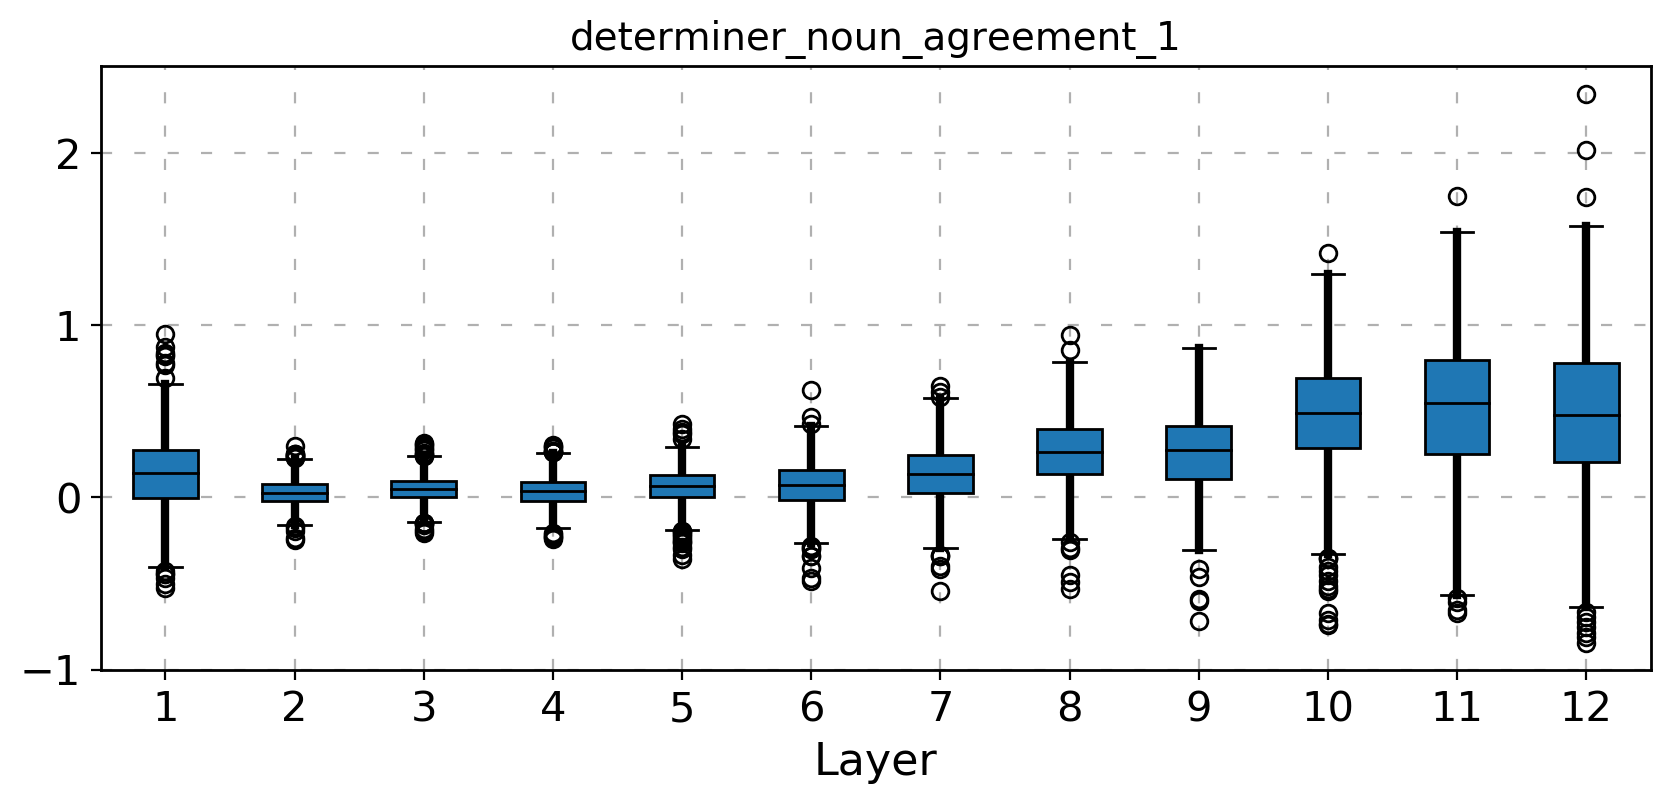

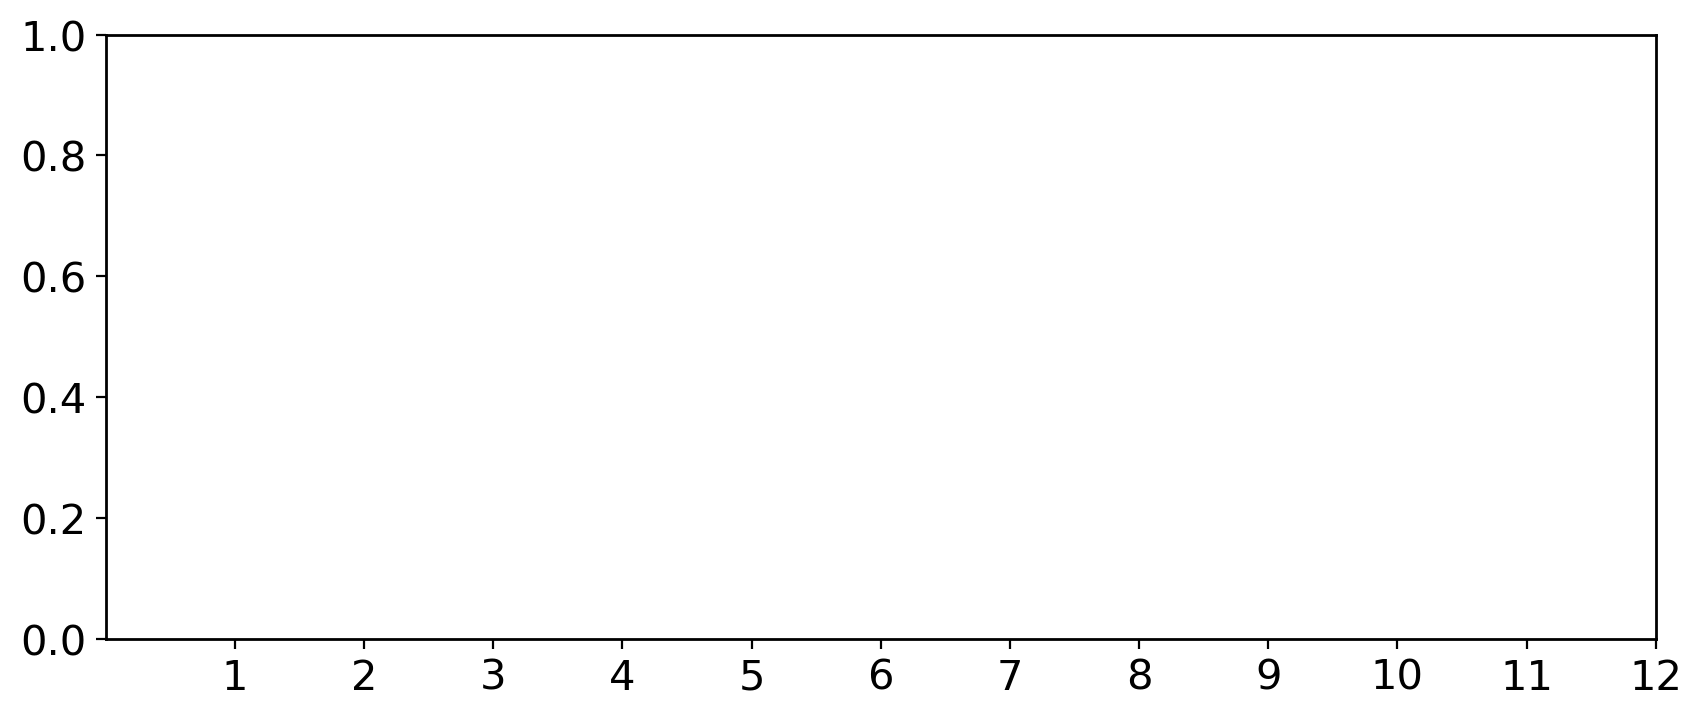

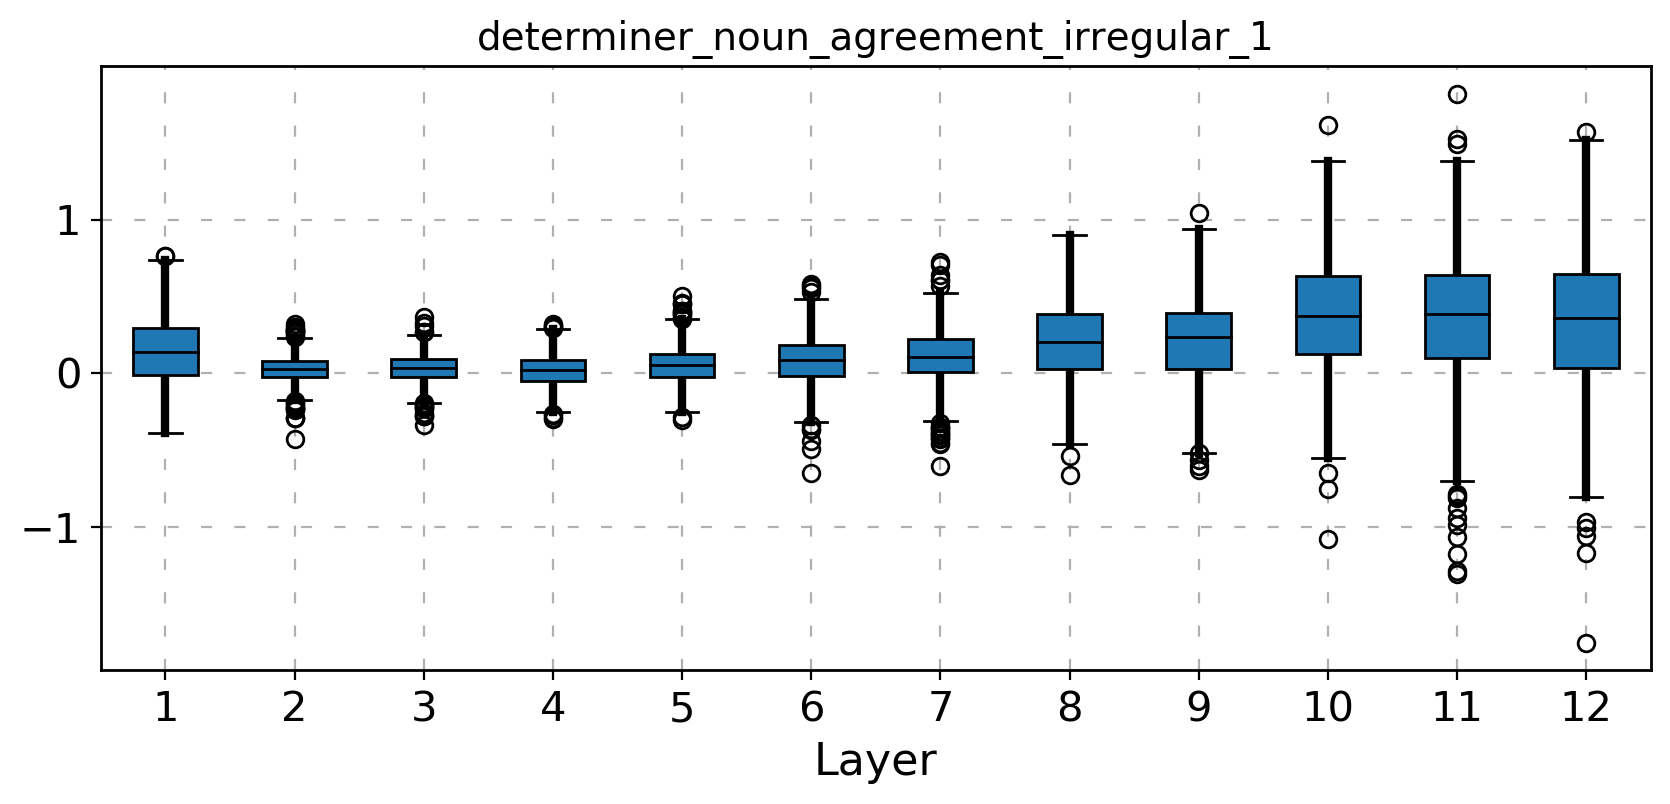

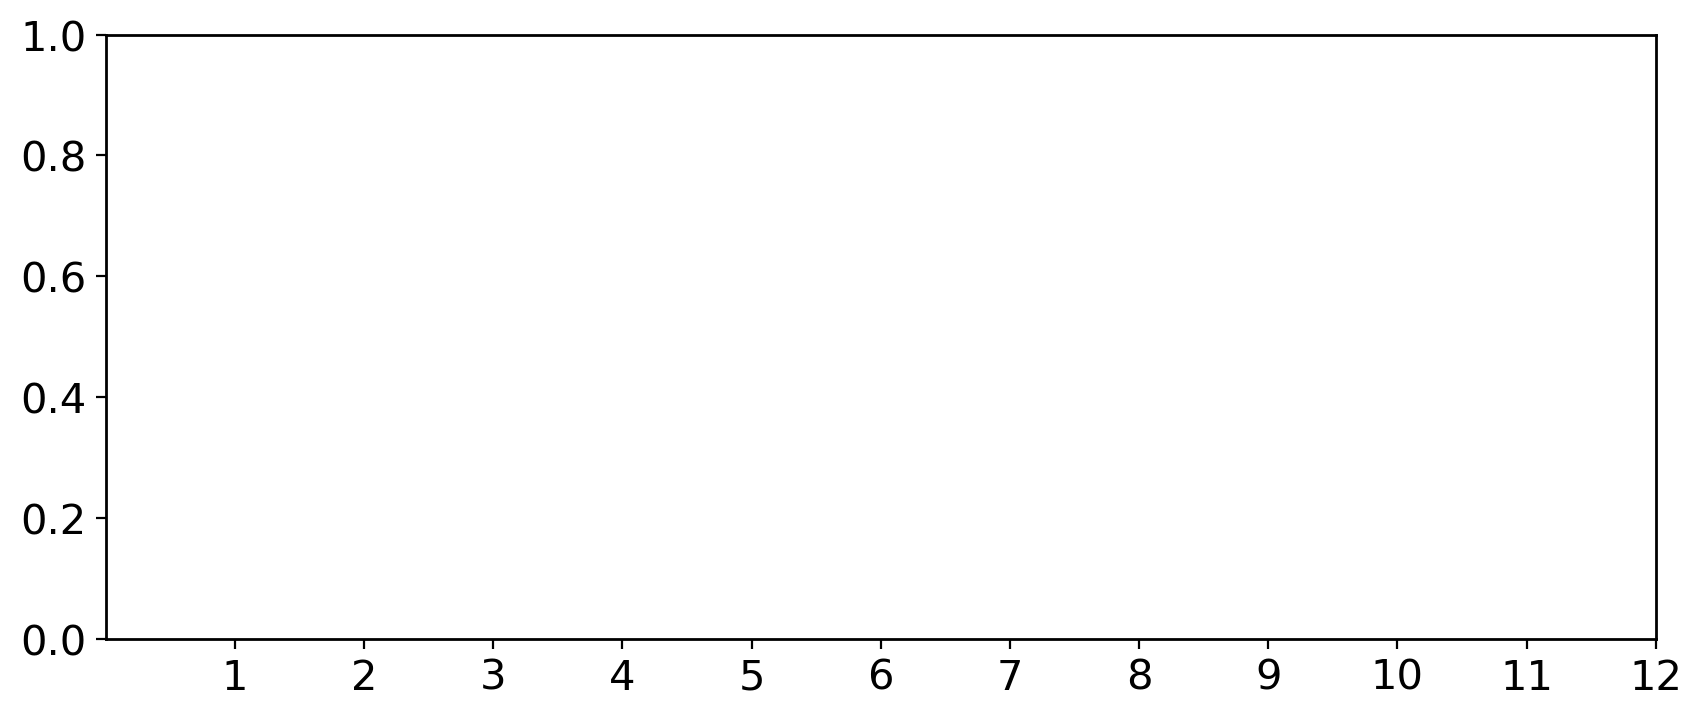

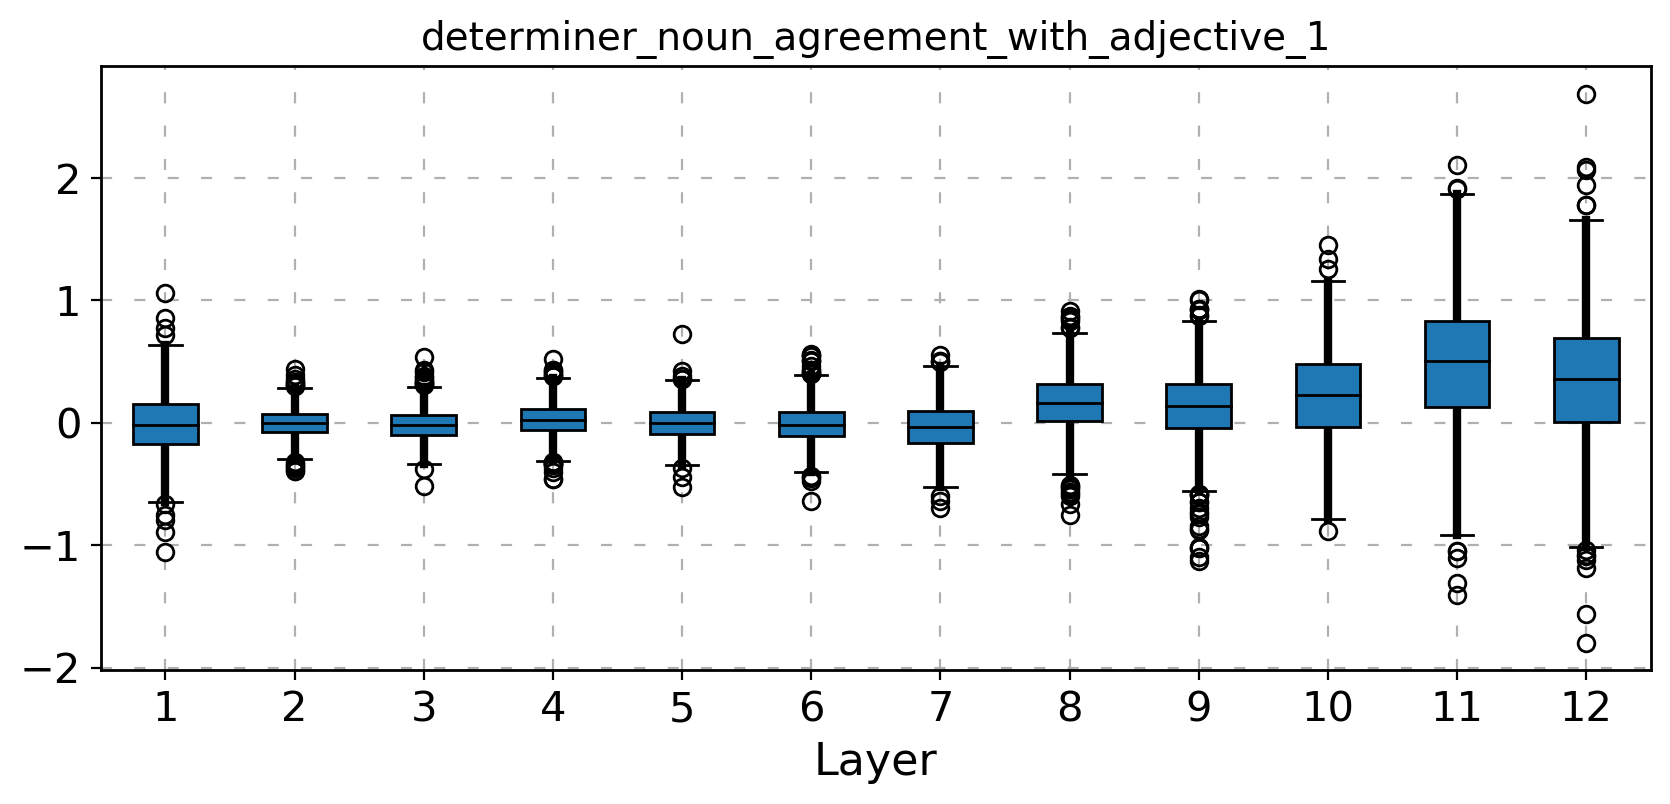

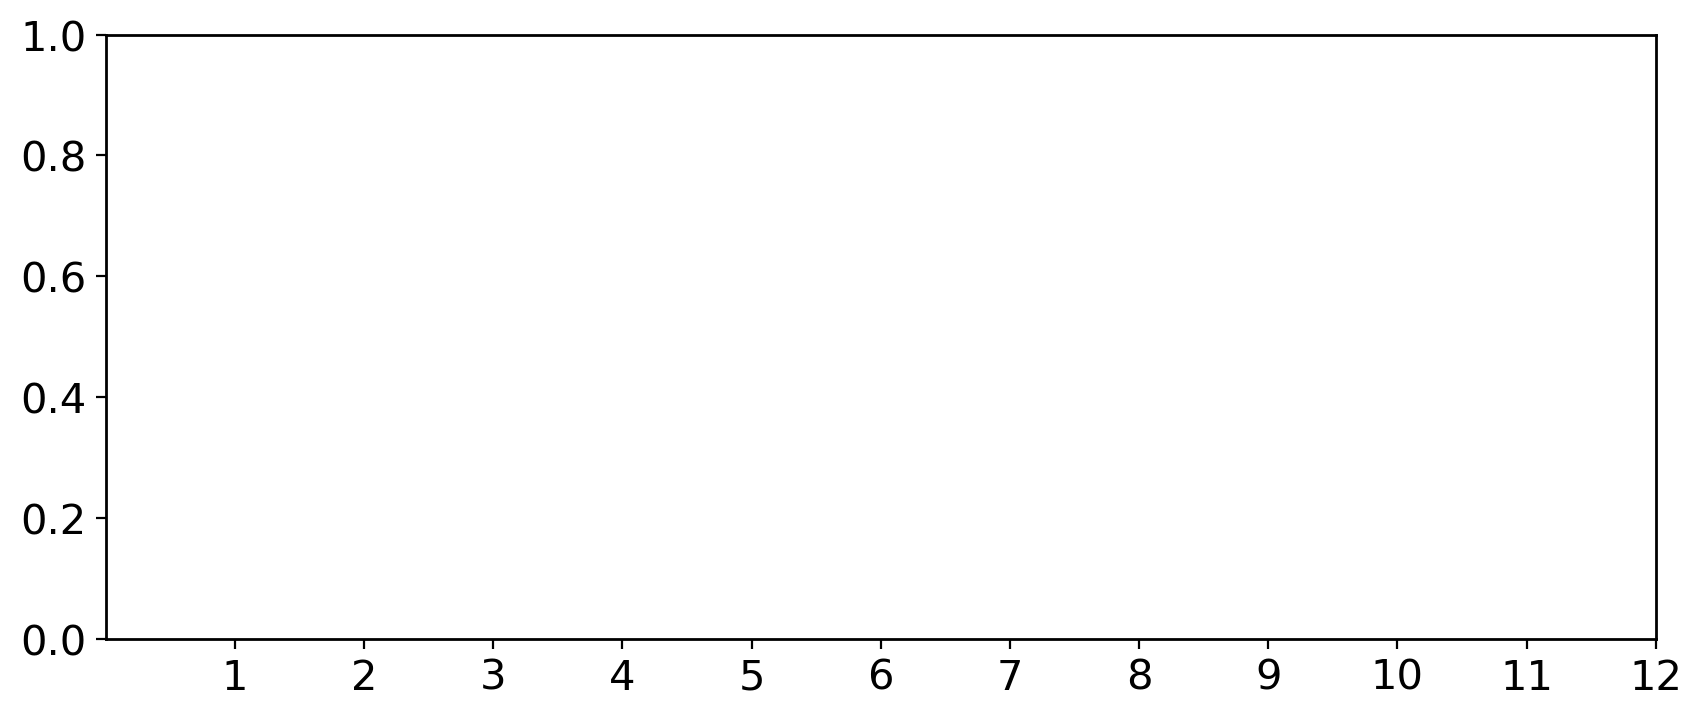

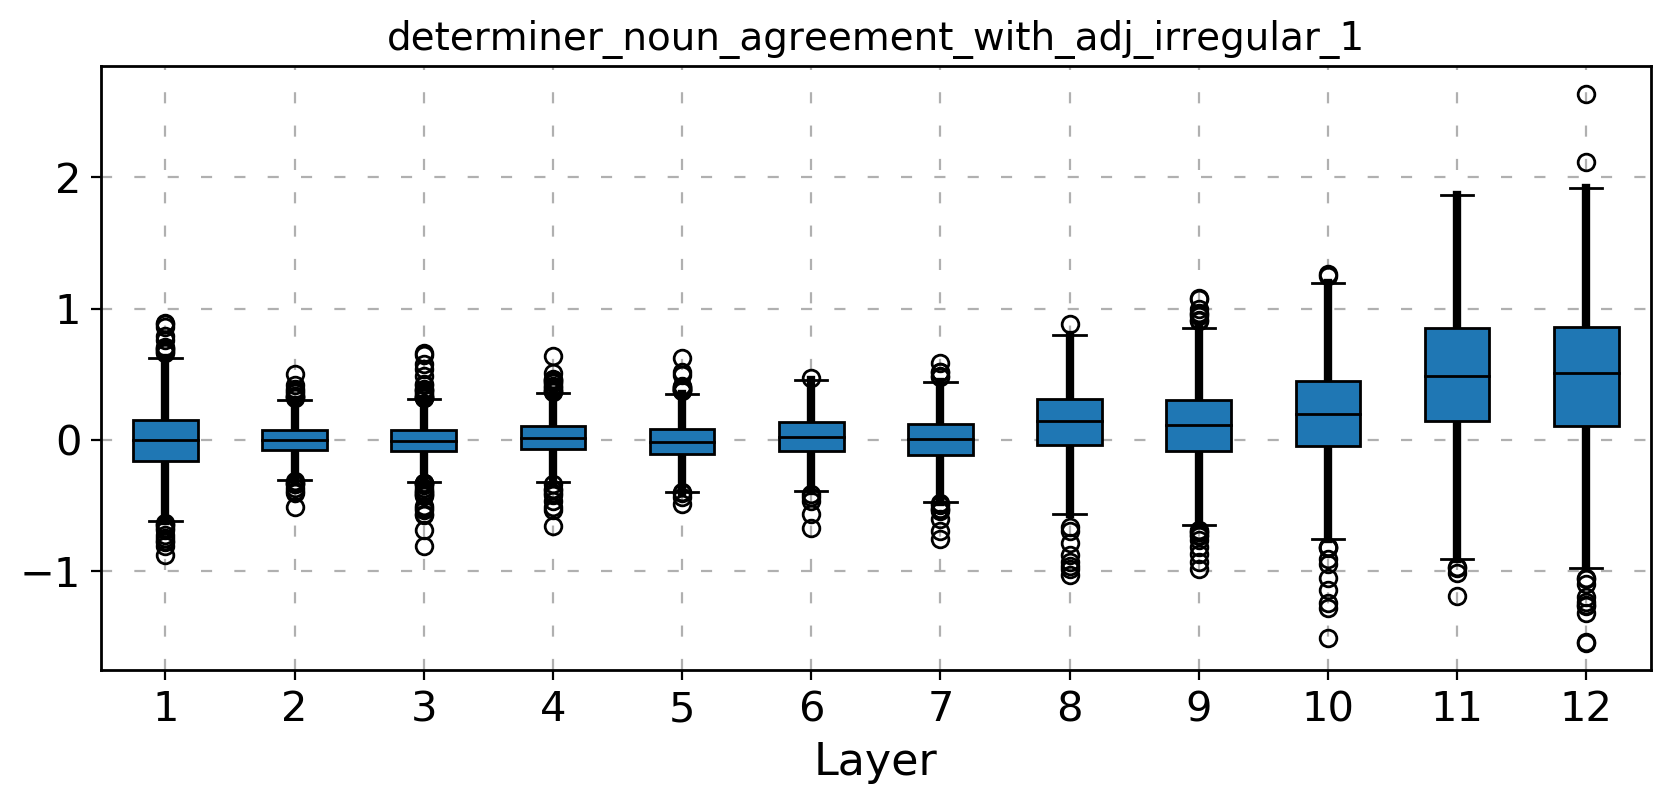

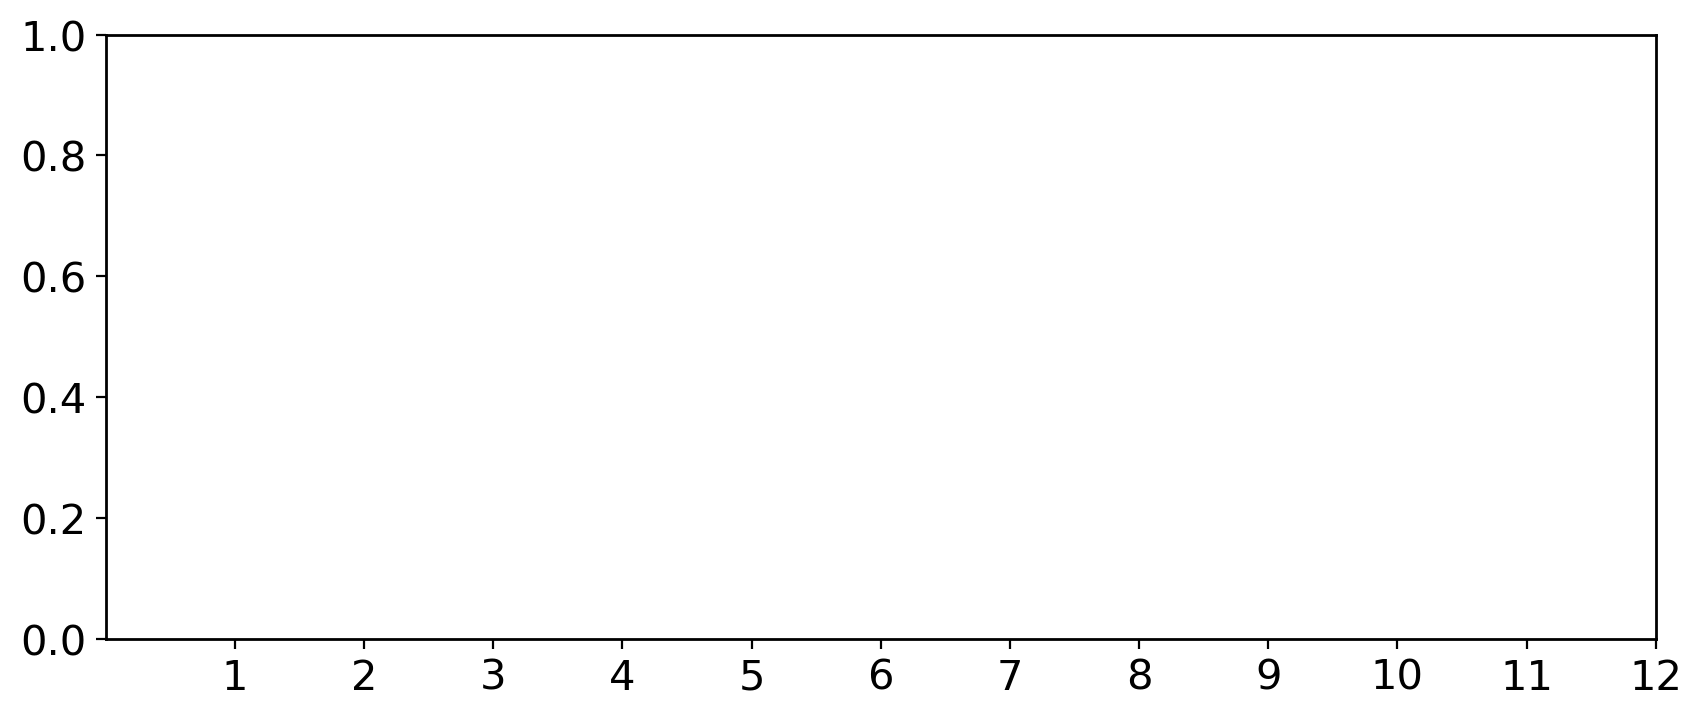

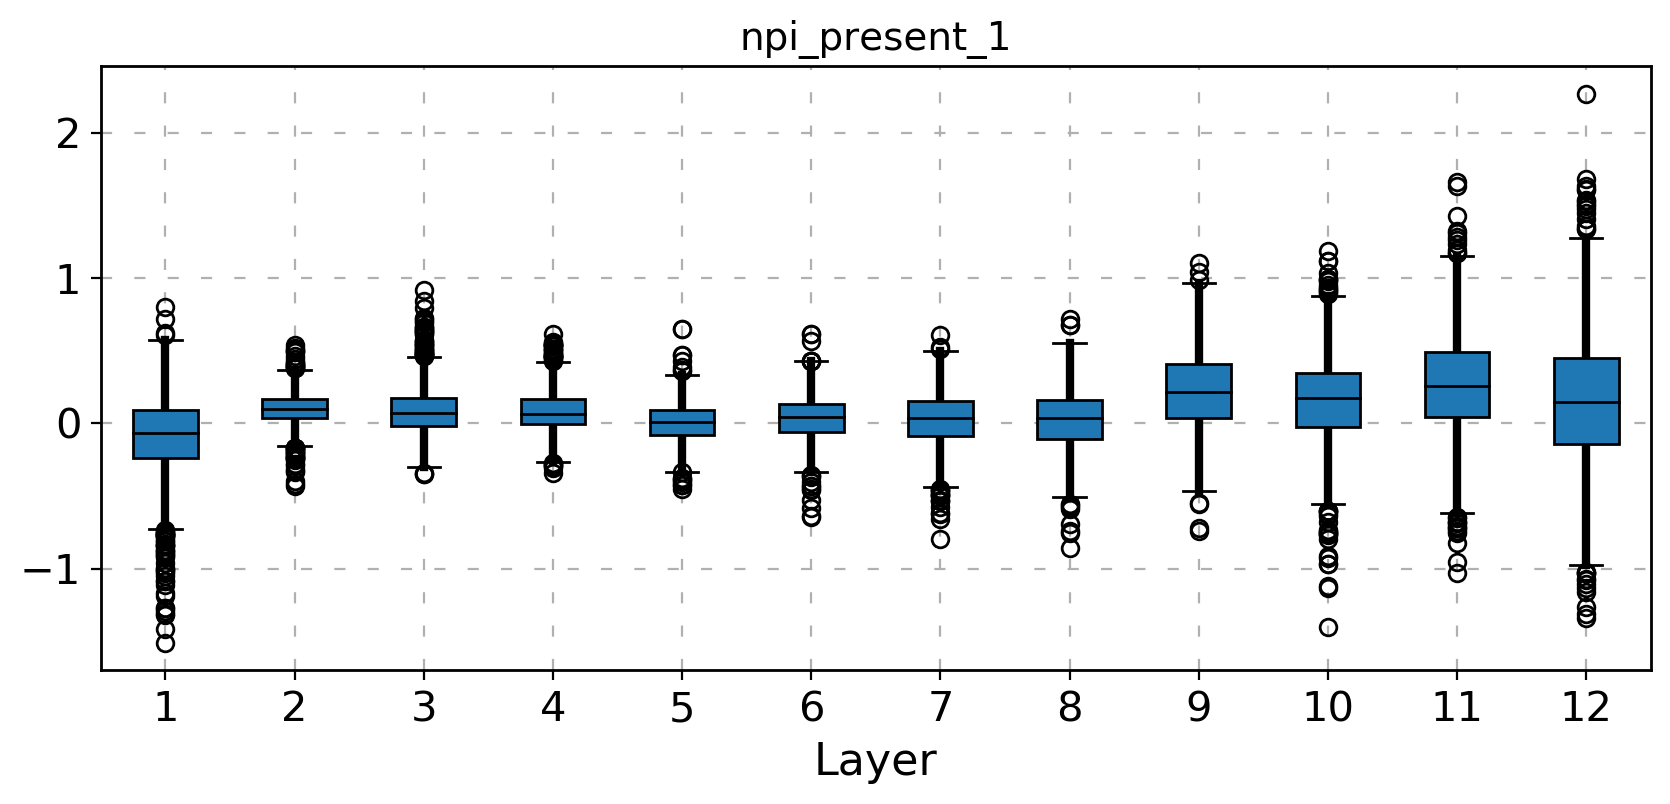

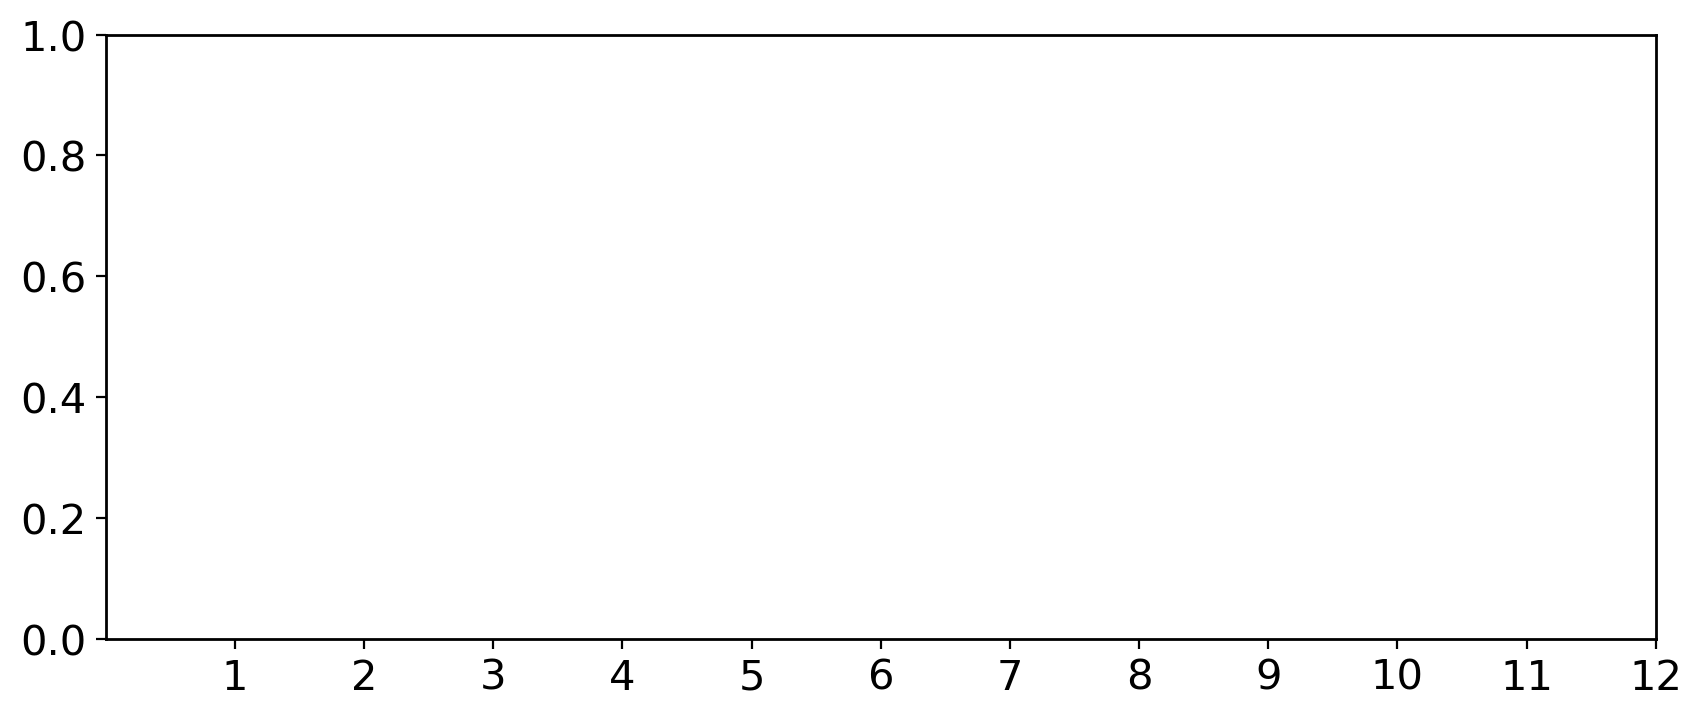

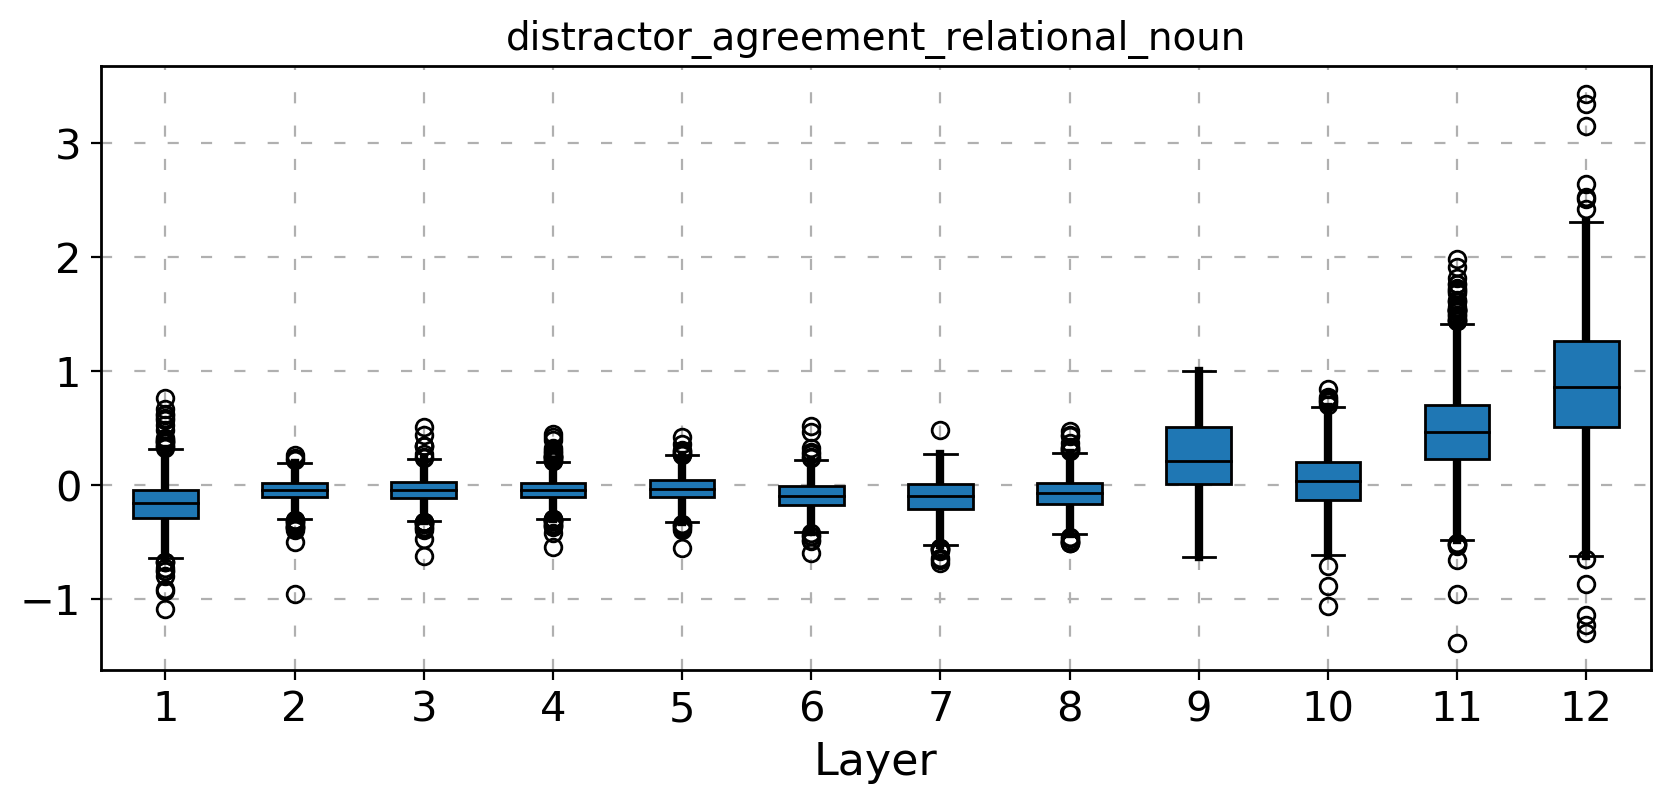

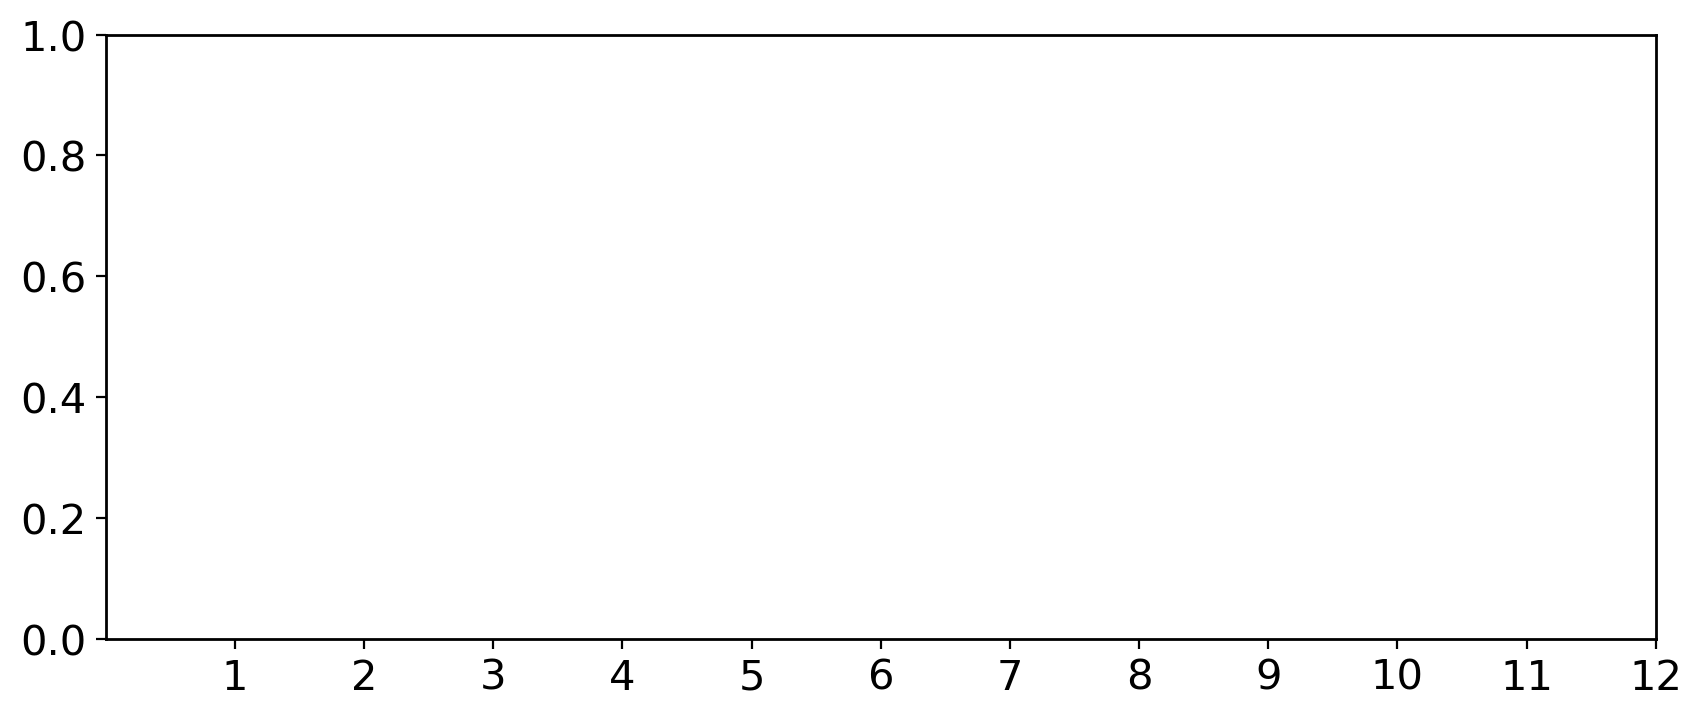

In [ ]:
import itertools

num_layers = 12

for dataset in datasets:
    # npi_present_1
    l = logits_diff_datasets[dataset]['logits_diff_mlp_layers']

    # short circuits at shortest nested list if table is jagged:
    list(map(list, zip(*l)))

    # discards no data if jagged and fills short nested lists with None
    transposed_l = list(map(list, itertools.zip_longest(*l, fillvalue=None)))

    colors = ['#82B366','#6C8EBF','#D79B00','#C98177']
    fig, ax = plt.subplots(figsize =(10, 4),dpi=200)
    box = ax.boxplot(transposed_l,whiskerprops=dict(linewidth=3.0),
                    patch_artist=True, showfliers=True)
    plt.setp(box['medians'], color='black')
    counter = 0
    # for i, patch in enumerate(box['boxes']):
    #     print(patch)
    #     patch.set_facecolor(colors[i])
    # ax.set_xticklabels(plot_dict.keys())
    #ax.set_ylim(0,1)
    ax.grid(True, linestyle=(0, (5, 10)));
    ax.set_title(dataset, size=14)
    ax.set_xlabel('Layer', fontsize=16);

    logits_diff_mlp_layers = np.array(logits_diff_datasets[dataset]['logits_diff_mlp_layers']).transpose()
    total_logits_diff = np.array(logits_diff_datasets[dataset]['total_logits_diff'])
    #corr_mlps_logit_diff = np.corrcoef(logits_diff_mlp_layers, total_logits_diff)[-1,:-1]

    # fig, ax = plt.subplots(figsize =(10, 4),dpi=200)
    # #ax.bar(np.arange(1,num_layers+1),corr_mlps_logit_diff)
    # ax.set_xticks(np.arange(1,num_layers+1))
    # ax.set_xticklabels(np.arange(1,num_layers+1), rotation=0)
    plt.show()